# Proyecto
## Clasificación de Sonidos Urbanos

**Universidad del Valle de Guatemala**\
**Facultad de Ingeniería**\
**Departamento de Ciencias de la Computación**\
**Deep Learning**

---
### Integrantes:
- Diego Leiva
- Pablo Orellana
- Maria Marta Ramirez
---

## Librerias

In [2]:
# Datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut

# Torch
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Utils
import os
from tqdm import tqdm
import random
import platform

# Advertencias
import warnings
warnings.filterwarnings("ignore") # Ignorar advertencias

## Metadatos

In [3]:
AUDIO_PATH = 'data/UrbanSound8K/audio/'

# Obtencion de metadatos
metadata = pd.read_csv('data/UrbanSound8K/metadata/UrbanSound8K.csv')
files = metadata['slice_file_name'].values
labels = metadata['classID'].values
folds = metadata['fold'].values
classes = metadata['class'].values

# Creacion de directorios
paths = [
    os.path.join(AUDIO_PATH + f"fold{fold}", file) for fold, file in zip(folds, files)
]

# Crear y ordenar el diccionario de mapeo classID -> class
class_mapping = dict(sorted(metadata[['classID', 'class']].drop_duplicates().set_index('classID')['class'].to_dict().items()))

# Ver el mapeo resultante
print("-"*15, " Mapeo de clases ", "-"*15)
for key, value in class_mapping.items():
    print(f"{key}: {value}")


---------------  Mapeo de clases  ---------------
0: air_conditioner
1: car_horn
2: children_playing
3: dog_bark
4: drilling
5: engine_idling
6: gun_shot
7: jackhammer
8: siren
9: street_music


## Configuracion de PyTorch CUDA

In [4]:
# Semilla para reproducibilidad
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Configuración de determinismo
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_info = ""

# Configuración de dispositivo
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    device_info = f'{torch.cuda.get_device_name(0)}'
else:
    device_info = f"{platform.processor()}"

print(f"Device: {device_info}")

Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU


## Dataset y Dataloader de Audio

In [5]:
class AudioDataset():
    def __init__(self, paths, labels, train=True):
        self.paths = paths
        self.labels = labels
        self.audio_length = 160000  # 4 segundos de audio
        self.train = train

        # Definir transformaciones con parámetros ajustados
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=22050,
            n_fft=2048,
            win_length=1024, 
            hop_length=512,  
            n_mels=128,     
            f_min=20,
            f_max=11025  # sample_rate/2
        )

        # Masking de la señal de audio
        self.time_masking = torchaudio.transforms.TimeMasking(time_mask_param=30)
        self.freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=20)
        

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        file = self.paths[idx]
        waveform, _ = torchaudio.load(file, normalize=True)
        mono = torch.mean(waveform, dim=0, keepdim=True)

        temp = torch.zeros([1, self.audio_length])
        if mono.numel() < self.audio_length:
            temp[:, :mono.numel()] = mono
        else:
            temp = mono[:, :self.audio_length]

        # Asignar audio mono 
        audio_mono = temp

        # Obtener espectrograma de Mel
        mel_spectrogram = self.mel_spec(audio_mono)

        # Aplicar masking en training
        if self.train:
            mel_spectrogram = self.time_masking(mel_spectrogram)
            mel_spectrogram = self.freq_masking(mel_spectrogram)
            
        # Normalización más robusta
        mel_spectrogram_norm = (mel_spectrogram - mel_spectrogram.mean()) / (mel_spectrogram.std() + 1e-7)


        feature_dict = {
            'feature_vector': mel_spectrogram_norm[0].permute(1, 0).clone().detach(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        
        return feature_dict

In [6]:
def collate_data(data):
    # Inicializar listas de features y labels
    features = []
    labels = []

    # Iterar sobre los datos
    for element in data:
        # Extraer feature y label
        feature = element["feature_vector"].to(device)
        label = element["label"].to(device)

        # Agregar a las listas
        features.append(feature)
        labels.append(label)

    # Realizar padding de los features y convertir labels a tensor
    feature = nn.utils.rnn.pad_sequence(features, batch_first=True, padding_value=0.)
    labels = torch.stack(labels).long()  # Asegurar que labels sea Long

    return feature, labels

## Modelo LSTM

In [7]:
class AudioLSTM(nn.Module):
    def __init__(self, feature_size, out_features, hidden_layers, layers, dropout):
        super().__init__()
        self.n_hidden = hidden_layers
        self.n_layers = layers
        self.n_feature = feature_size

        # Capa LSTM
        self.lstm = nn.LSTM(
            input_size=self.n_feature,
            hidden_size=self.n_hidden,
            num_layers=self.n_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=True
        )

        # Aplicar mecanismo de atención
        self.attention = nn.Sequential(
            nn.Linear(self.n_hidden * 2, self.n_hidden),
            nn.Tanh(),
            nn.Linear(self.n_hidden, 1)
        )

        # Capa de dropout
        self.dropout = nn.Dropout(dropout)

        # Primer capa lineal con batch normalization
        self.fc1 = nn.Linear(self.n_hidden * 2, self.n_hidden)
        self.batch_norm1 = nn.BatchNorm1d(self.n_hidden)
        
        # Segunda capa lineal con batch normalization
        self.fc2 = nn.Linear(self.n_hidden, int(self.n_hidden/2))
        self.batch_norm2 = nn.BatchNorm1d(int(self.n_hidden/2))
        
        # Capa de salida
        self.fc3 = nn.Linear(int(self.n_hidden/2), out_features)

    # Attention mechanism
    def attention_net(self, lstm_output):
        # Obtener el tamaño de la secuencia 
        attention_weights = self.attention(lstm_output)
        attention_weights = F.softmax(attention_weights, dim=1)

        # Aplicar atención a la salida de la LSTM
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector

    # Forward pass
    def forward(self, x, hidden):
        # X shape -> (batch_size, sequence_length, n_features)
        # Salida de la capa LSTM
        l_out, l_hidden = self.lstm(x, hidden)

        # Aplicar mecanismo de atención
        attn_out = self.attention_net(l_out)

        # Out shape -> (batch_size, sequence_length, n_hidden*direcction)
        # Aplicar Dropout a la salida de la capa LSTM
        out = self.dropout(attn_out)
        
        identity = out
        # Paso a través de la primera capa lineal
        out = self.fc1(out) # Tomar la salida de la capa LSTM con atención
        out = self.batch_norm1(out)  # Aplicar batch normalization

        # Aplicar función de activación ReLU
        out = F.relu(out)

        # Paso a través de la segunda capa lineal
        out = self.fc2(out)
        out = self.batch_norm2(out)

        # Aplicar función de activación ReLU
        out = F.relu(out)

        # Aplicar dropout
        out = self.dropout(out)

        # Paso a través de la capa de salida
        out = self.fc3(out)
        
        # Retornar el output y el hidden state
        return out, l_hidden
    

    # Inicializar hidden state
    def init_hidden(self, batch_size):
        # Obtener pesos de la primera capa
        weight = next(self.parameters()).data

        # Inicializar hidden state con ceros
        hidden = (weight.new(self.n_layers * 2, batch_size, self.n_hidden).zero_().to(device),
                  weight.new(self.n_layers * 2, batch_size, self.n_hidden).zero_().to(device))
        
        # Retornar hidden state
        return hidden

In [8]:
def save_model(state, path):
    torch.save(state, path)

### Loop de entrenamiento

In [9]:
def train_model(data_loader, model, epoch, optimizer, device):
    # Inicializar lista de perdidas, accuracy, labels y predicciones
    losses = []
    labels = []
    predictions = []

    # Establecer modelo en modo de entrenamiento
    model.train()

    # Crear barra de progreso
    loop = tqdm(data_loader)

    # Iterar sobre los datos
    for batch_idx, (data, target) in enumerate(loop):
        # Enviar datos al dispositivo
        data = data.to(device)
        target = target.to(device)

        # Limpiar gradientes
        model.zero_grad()

        # Inicializar hidden state y output
        output, _ = model(data, model.init_hidden(data.size(0)))
        
        # Calcular perdida
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward() # Backpropagation

        # Optimizar
        optimizer.step()

        # Agregar perdida
        losses.append(loss.item())
        
        # Obtener mayor valor de output
        winners = output.argmax(dim=1)
        
        # Agregar labels y predicciones
        labels += torch.flatten(target).cpu().tolist()
        predictions += torch.flatten(winners).cpu().tolist()

        # Calcular accuracy del batch
        batch_accuracy = (winners == target).sum().float() / float(target.size(0))

        # Actualizar barra de progreso
        loop.set_description(f"TRAIN -> Epoch {epoch} | Batch: {batch_idx+1}/{len(data_loader)} | Loss: {loss.item():.4f} | Accuracy: {batch_accuracy:.4f}")

    # Obtener promedio de perdidas y accuracy total del epoch
    total_loss = np.mean(losses)
    total_accuracy = np.mean(np.array(labels) == np.array(predictions))

    # Obterner reporte de clasificacion de la epoch
    train_report = classification_report(labels, predictions, output_dict=True)
    # Obtener matriz de confusion de la epoch
    train_confusion_matrix = confusion_matrix(labels, predictions)

    # Imprimir métricas finales usando tqdm.write
    tqdm.write(f"TRAIN -> Epoch {epoch} | Final Loss: {total_loss:.4f} | Final Accuracy: {total_accuracy:.4f}")

    # Retornar perdida, accuracy, reporte y matriz de la epoca
    return total_loss, total_accuracy, train_confusion_matrix, train_report

### Loop de Validacion

In [10]:
def validate(data_loader, model, device):
    # Inicializar lista de perdidas, accuracy, labels
    losses = []
    labels = []
    predictions = []
    
    # Configurar modelo en modo de evaluacion
    model.eval()

    # Sin actualizar gradientes
    with torch.no_grad():
        # Crear barra de progreso
        loop = tqdm(data_loader)

        # Iterar sobre los datos
        for batch_idx, (data, target) in enumerate(loop):
            # Enviar datos al dispositivo
            data = data.to(device)
            target = target.to(device)

            # Inicializar hidden state y output
            output, _ = model(data, model.init_hidden(data.size(0)))

            # Calcular perdida
            loss = nn.CrossEntropyLoss()(output, target)
            # Agregar perdida
            losses.append(loss.item())

            # Obtener mayor valor de output
            winners = output.argmax(dim=1)

            # Agregar lables y predicciones
            labels += torch.flatten(target).cpu()
            predictions += torch.flatten(winners).cpu()

            # Calcular accuracy
            batch_accuracy = (winners == target).sum().float() / float(target.size(0))

            loop.set_description(f"VALIDATE -> Batch: {batch_idx+1}/{len(data_loader)} | Accuracy: {batch_accuracy:.4f}")

    # Calcular accuracy total de toda la época de validación
    total_accuracy = np.mean(np.array(labels) == np.array(predictions))
    # Obtener promedio de perdidas de la época de validación
    total_loss = np.mean(losses)

    # Obtener reporte de clasificación de la época de validación
    val_report = classification_report(labels, predictions, output_dict=True)
    # Obtener matriz de confusión de la época de validación
    val_confusion_matrix = confusion_matrix(labels, predictions)

    # Imprimir métricas finales usando tqdm.write
    tqdm.write(f"VALIDATE -> Final Loss: {total_loss:.4f} | Final Accuracy: {total_accuracy:.4f}")


    # Retornar perdida, accuracy, reporte y matriz de la época de validación
    return total_loss, total_accuracy, val_confusion_matrix, val_report

## Configuracion inicial

In [11]:
# Constantes
EPOCHS = 15 # Cantidad de épocas disminuida debido a overfitting
OUT_FEATURE = 10 # Numero de clases
SCHEDULER_PATIENCE = 5 # Paciencia para el scheduler
FEATURE_SIZE = 128 # Tamaño de los features (n_mels)

## Loop Principal

En este loop se hacen los splits train-test para los 10 Folds, de esta manera se entrena el modelo con 9 Folds y se Valida con el Sobrante. Obteniendo metricas de rendimiento para la mejor epoca en cada Fold.

In [ ]:
# Leave One Group Out Cross Validation
logo = LeaveOneGroupOut()

# Lista de diccionarios de Rendimiento de cada fold
folds_performance = []

# Loop de entrenamiento por epocas y folds
for fold_idx, (train_idx, val_idx) in enumerate(logo.split(paths, labels, folds)):
    
    # Diccionario de resultados del fold actual
    results = {
        'fold': fold_idx + 1,
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'train_report': None,
        'val_report': None,
        'train_matrix': None,
        'val_matrix': None,
        'best_accuracy': 0,
        'best_epoch': 0
    }

    # Imprimir separador si no es el primer fold
    if fold_idx > 0:
        print(f"\n")
    
    print("-"*15, f" FOLD {fold_idx+1} ", "-"*15)

    # Dividir datos en train y validation sets
    train_paths = [paths[i] for i in train_idx]
    val_paths = [paths[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    # Crear datasets
    train_dataset = AudioDataset(train_paths, train_labels, train=True)
    val_dataset = AudioDataset(val_paths, val_labels, train=False)

    # Crear dataloaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, collate_fn=collate_data)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_data)

    # Entrenamiento del Modelo
    model = AudioLSTM(feature_size=FEATURE_SIZE, 
                      out_features=OUT_FEATURE, 
                      hidden_layers=256, 
                      layers=2, 
                      dropout=0.3).to(device)
    
    # Crear optimizador AdamW y scheduler
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3) # Peso decaimiento
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=SCHEDULER_PATIENCE, factor=0.1) # Reducir tasa de aprendizaje

    # Loop de entrenamiento
    for epoch in range(EPOCHS):
        
        # Entrenar modelo y obtener perdidas y accuracy
        epoch_train_loss, epoch_train_acc, epoch_train_matrix, epoch_train_report = train_model(train_loader, model, epoch, optimizer, device)

        # Validar modelo y obtener accuracy
        epoch_val_loss, epoch_val_acc, epoch_val_matrix, epoch_val_report = validate(val_loader, model, device)

        # Guardar perdidas y accuracies del epoch actual
        results['train_losses'].append(epoch_train_loss)
        results['val_losses'].append(epoch_val_loss)
        results['train_accuracies'].append(epoch_train_acc)
        results['val_accuracies'].append(epoch_val_acc)
        
        # Actualizar el scheduler y guardar el mejor modelo
        scheduler.step(epoch_train_acc)
        
        # Guardar el mejor modelo y metricas de desempeño para el fold actual
        if epoch_val_acc > results['best_accuracy']:
            # Resetear contador de paciencia
            no_improvement = 0

            # Actualizar mejor accuracy y epoch
            results['best_accuracy'] = epoch_val_acc
            results['best_epoch'] = epoch
            
            # Actualizar reportes y matrices
            results['train_report'] = epoch_train_report
            results['val_report'] = epoch_val_report
            results['train_matrix'] = epoch_train_matrix
            results['val_matrix'] = epoch_val_matrix

            # Guardar mejor modelo hasta ahora
            save_model({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'models/lstmv2_fold{fold_idx + 1}.pth')

    # Terminar fold y guardar resultados
    folds_performance.append(results)

---------------  FOLD 1  ---------------


TRAIN -> Epoch 0 | Batch: 62/62 | Loss: 2.1130 | Accuracy: 0.2941: 100%|██████████| 62/62 [00:47<00:00,  1.32it/s]


TRAIN -> Epoch 0 | Final Loss: 2.1124 | Final Accuracy: 0.2741


VALIDATE -> Batch: 7/7 | Accuracy: 0.4667: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


VALIDATE -> Final Loss: 1.8188 | Final Accuracy: 0.3677


TRAIN -> Epoch 1 | Batch: 62/62 | Loss: 1.9714 | Accuracy: 0.3137: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


TRAIN -> Epoch 1 | Final Loss: 1.9506 | Final Accuracy: 0.3123


VALIDATE -> Batch: 7/7 | Accuracy: 0.4952: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


VALIDATE -> Final Loss: 1.6952 | Final Accuracy: 0.4032


TRAIN -> Epoch 2 | Batch: 62/62 | Loss: 1.8880 | Accuracy: 0.3922: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


TRAIN -> Epoch 2 | Final Loss: 1.8680 | Final Accuracy: 0.3471


VALIDATE -> Batch: 7/7 | Accuracy: 0.5429: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


VALIDATE -> Final Loss: 1.6108 | Final Accuracy: 0.4330


TRAIN -> Epoch 3 | Batch: 62/62 | Loss: 1.4370 | Accuracy: 0.4902: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 3 | Final Loss: 1.7636 | Final Accuracy: 0.3959


VALIDATE -> Batch: 7/7 | Accuracy: 0.5619: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


VALIDATE -> Final Loss: 1.5390 | Final Accuracy: 0.4651


TRAIN -> Epoch 4 | Batch: 62/62 | Loss: 1.2874 | Accuracy: 0.6275: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


TRAIN -> Epoch 4 | Final Loss: 1.6907 | Final Accuracy: 0.4228


VALIDATE -> Batch: 7/7 | Accuracy: 0.6095: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


VALIDATE -> Final Loss: 1.5542 | Final Accuracy: 0.5063


TRAIN -> Epoch 5 | Batch: 62/62 | Loss: 1.2179 | Accuracy: 0.7059: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 5 | Final Loss: 1.6126 | Final Accuracy: 0.4685


VALIDATE -> Batch: 7/7 | Accuracy: 0.6190: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


VALIDATE -> Final Loss: 1.4971 | Final Accuracy: 0.4822


TRAIN -> Epoch 6 | Batch: 62/62 | Loss: 0.9330 | Accuracy: 0.8235: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 6 | Final Loss: 1.5399 | Final Accuracy: 0.4927


VALIDATE -> Batch: 7/7 | Accuracy: 0.5810: 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


VALIDATE -> Final Loss: 1.4096 | Final Accuracy: 0.5292


TRAIN -> Epoch 7 | Batch: 62/62 | Loss: 0.8773 | Accuracy: 0.8627: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 7 | Final Loss: 1.4627 | Final Accuracy: 0.5218


VALIDATE -> Batch: 7/7 | Accuracy: 0.6952: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


VALIDATE -> Final Loss: 1.3462 | Final Accuracy: 0.5361


TRAIN -> Epoch 8 | Batch: 62/62 | Loss: 0.7752 | Accuracy: 0.8824: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 8 | Final Loss: 1.3772 | Final Accuracy: 0.5478


VALIDATE -> Batch: 7/7 | Accuracy: 0.5810: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


VALIDATE -> Final Loss: 1.3973 | Final Accuracy: 0.5487


TRAIN -> Epoch 9 | Batch: 62/62 | Loss: 0.6367 | Accuracy: 0.9020: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


TRAIN -> Epoch 9 | Final Loss: 1.3064 | Final Accuracy: 0.5837


VALIDATE -> Batch: 7/7 | Accuracy: 0.6762: 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


VALIDATE -> Final Loss: 1.3407 | Final Accuracy: 0.5934


TRAIN -> Epoch 10 | Batch: 62/62 | Loss: 0.6194 | Accuracy: 0.9020: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 10 | Final Loss: 1.2436 | Final Accuracy: 0.5975


VALIDATE -> Batch: 7/7 | Accuracy: 0.6571: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


VALIDATE -> Final Loss: 1.2768 | Final Accuracy: 0.6231


TRAIN -> Epoch 11 | Batch: 62/62 | Loss: 0.5809 | Accuracy: 0.8824: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 11 | Final Loss: 1.1718 | Final Accuracy: 0.6282


VALIDATE -> Batch: 7/7 | Accuracy: 0.6762: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


VALIDATE -> Final Loss: 1.3410 | Final Accuracy: 0.5647


TRAIN -> Epoch 12 | Batch: 62/62 | Loss: 0.5263 | Accuracy: 0.9412: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


TRAIN -> Epoch 12 | Final Loss: 1.1162 | Final Accuracy: 0.6500


VALIDATE -> Batch: 7/7 | Accuracy: 0.6857: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


VALIDATE -> Final Loss: 1.3062 | Final Accuracy: 0.6231


TRAIN -> Epoch 13 | Batch: 62/62 | Loss: 0.4613 | Accuracy: 0.9216: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


TRAIN -> Epoch 13 | Final Loss: 1.0350 | Final Accuracy: 0.6792


VALIDATE -> Batch: 7/7 | Accuracy: 0.7143: 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


VALIDATE -> Final Loss: 1.3726 | Final Accuracy: 0.5785


TRAIN -> Epoch 14 | Batch: 62/62 | Loss: 0.3859 | Accuracy: 0.9804: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 14 | Final Loss: 0.9617 | Final Accuracy: 0.7043


VALIDATE -> Batch: 7/7 | Accuracy: 0.7048: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


VALIDATE -> Final Loss: 1.2830 | Final Accuracy: 0.5911


---------------  FOLD 2  ---------------


TRAIN -> Epoch 0 | Batch: 62/62 | Loss: 2.0963 | Accuracy: 0.2222: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 0 | Final Loss: 2.1298 | Final Accuracy: 0.2584


VALIDATE -> Batch: 7/7 | Accuracy: 0.2417: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


VALIDATE -> Final Loss: 1.7595 | Final Accuracy: 0.3570


TRAIN -> Epoch 1 | Batch: 62/62 | Loss: 1.7011 | Accuracy: 0.5278: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 1 | Final Loss: 1.9475 | Final Accuracy: 0.3174


VALIDATE -> Batch: 7/7 | Accuracy: 0.5167: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


VALIDATE -> Final Loss: 1.6447 | Final Accuracy: 0.4797


TRAIN -> Epoch 2 | Batch: 62/62 | Loss: 1.5271 | Accuracy: 0.6111: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 2 | Final Loss: 1.8263 | Final Accuracy: 0.3652


VALIDATE -> Batch: 7/7 | Accuracy: 0.3917: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 1.6621 | Final Accuracy: 0.4482


TRAIN -> Epoch 3 | Batch: 62/62 | Loss: 1.1395 | Accuracy: 0.6667: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


TRAIN -> Epoch 3 | Final Loss: 1.7273 | Final Accuracy: 0.4023


VALIDATE -> Batch: 7/7 | Accuracy: 0.3167: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


VALIDATE -> Final Loss: 1.6051 | Final Accuracy: 0.4392


TRAIN -> Epoch 4 | Batch: 62/62 | Loss: 0.9245 | Accuracy: 0.8056: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


TRAIN -> Epoch 4 | Final Loss: 1.6498 | Final Accuracy: 0.4349


VALIDATE -> Batch: 7/7 | Accuracy: 0.4750: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


VALIDATE -> Final Loss: 1.6877 | Final Accuracy: 0.4482


TRAIN -> Epoch 5 | Batch: 62/62 | Loss: 0.8993 | Accuracy: 0.7778: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 5 | Final Loss: 1.5849 | Final Accuracy: 0.4720


VALIDATE -> Batch: 7/7 | Accuracy: 0.2500: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


VALIDATE -> Final Loss: 1.6069 | Final Accuracy: 0.4448


TRAIN -> Epoch 6 | Batch: 62/62 | Loss: 0.6453 | Accuracy: 0.9444: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 6 | Final Loss: 1.4963 | Final Accuracy: 0.4991


VALIDATE -> Batch: 7/7 | Accuracy: 0.4500: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


VALIDATE -> Final Loss: 1.6187 | Final Accuracy: 0.4775


TRAIN -> Epoch 7 | Batch: 62/62 | Loss: 0.6648 | Accuracy: 0.8333: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


TRAIN -> Epoch 7 | Final Loss: 1.4326 | Final Accuracy: 0.5324


VALIDATE -> Batch: 7/7 | Accuracy: 0.5583: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


VALIDATE -> Final Loss: 1.6612 | Final Accuracy: 0.4966


TRAIN -> Epoch 8 | Batch: 62/62 | Loss: 0.4928 | Accuracy: 0.9722: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 8 | Final Loss: 1.3424 | Final Accuracy: 0.5667


VALIDATE -> Batch: 7/7 | Accuracy: 0.5417: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


VALIDATE -> Final Loss: 1.7205 | Final Accuracy: 0.4865


TRAIN -> Epoch 9 | Batch: 62/62 | Loss: 0.5843 | Accuracy: 0.9167: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 9 | Final Loss: 1.2720 | Final Accuracy: 0.6020


VALIDATE -> Batch: 7/7 | Accuracy: 0.5750: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


VALIDATE -> Final Loss: 1.7271 | Final Accuracy: 0.4865


TRAIN -> Epoch 10 | Batch: 62/62 | Loss: 0.5140 | Accuracy: 0.9444: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


TRAIN -> Epoch 10 | Final Loss: 1.2070 | Final Accuracy: 0.6226


VALIDATE -> Batch: 7/7 | Accuracy: 0.4500: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


VALIDATE -> Final Loss: 1.5645 | Final Accuracy: 0.5056


TRAIN -> Epoch 11 | Batch: 62/62 | Loss: 0.5536 | Accuracy: 0.9167: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 11 | Final Loss: 1.1283 | Final Accuracy: 0.6518


VALIDATE -> Batch: 7/7 | Accuracy: 0.4833: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


VALIDATE -> Final Loss: 1.5544 | Final Accuracy: 0.4966


TRAIN -> Epoch 12 | Batch: 62/62 | Loss: 0.3835 | Accuracy: 0.8889: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 12 | Final Loss: 1.0811 | Final Accuracy: 0.6724


VALIDATE -> Batch: 7/7 | Accuracy: 0.4417: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


VALIDATE -> Final Loss: 1.5403 | Final Accuracy: 0.5056


TRAIN -> Epoch 13 | Batch: 62/62 | Loss: 0.3205 | Accuracy: 0.9444: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 13 | Final Loss: 0.9839 | Final Accuracy: 0.7059


VALIDATE -> Batch: 7/7 | Accuracy: 0.4167: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


VALIDATE -> Final Loss: 1.5214 | Final Accuracy: 0.5056


TRAIN -> Epoch 14 | Batch: 62/62 | Loss: 0.2117 | Accuracy: 1.0000: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 14 | Final Loss: 0.9497 | Final Accuracy: 0.7179


VALIDATE -> Batch: 7/7 | Accuracy: 0.4833: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


VALIDATE -> Final Loss: 1.5880 | Final Accuracy: 0.5383


---------------  FOLD 3  ---------------


TRAIN -> Epoch 0 | Batch: 61/61 | Loss: 2.1661 | Accuracy: 0.2598: 100%|██████████| 61/61 [00:35<00:00,  1.72it/s]


TRAIN -> Epoch 0 | Final Loss: 2.1310 | Final Accuracy: 0.2555


VALIDATE -> Batch: 8/8 | Accuracy: 0.4828: 100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


VALIDATE -> Final Loss: 1.8695 | Final Accuracy: 0.3989


TRAIN -> Epoch 1 | Batch: 61/61 | Loss: 1.6932 | Accuracy: 0.3701: 100%|██████████| 61/61 [00:35<00:00,  1.71it/s]


TRAIN -> Epoch 1 | Final Loss: 1.9254 | Final Accuracy: 0.3228


VALIDATE -> Batch: 8/8 | Accuracy: 0.2069: 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


VALIDATE -> Final Loss: 1.7969 | Final Accuracy: 0.3092


TRAIN -> Epoch 2 | Batch: 61/61 | Loss: 1.6464 | Accuracy: 0.4803: 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 2 | Final Loss: 1.8148 | Final Accuracy: 0.3522


VALIDATE -> Batch: 8/8 | Accuracy: 0.4483: 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


VALIDATE -> Final Loss: 1.7518 | Final Accuracy: 0.3643


TRAIN -> Epoch 3 | Batch: 61/61 | Loss: 1.4680 | Accuracy: 0.4882: 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 3 | Final Loss: 1.7457 | Final Accuracy: 0.3875


VALIDATE -> Batch: 8/8 | Accuracy: 0.5172: 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


VALIDATE -> Final Loss: 1.7076 | Final Accuracy: 0.3665


TRAIN -> Epoch 4 | Batch: 61/61 | Loss: 1.3612 | Accuracy: 0.5984: 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 4 | Final Loss: 1.6618 | Final Accuracy: 0.4386


VALIDATE -> Batch: 8/8 | Accuracy: 0.6552: 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


VALIDATE -> Final Loss: 1.7297 | Final Accuracy: 0.3697


TRAIN -> Epoch 5 | Batch: 61/61 | Loss: 1.2440 | Accuracy: 0.5906: 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 5 | Final Loss: 1.5810 | Final Accuracy: 0.4695


VALIDATE -> Batch: 8/8 | Accuracy: 0.6552: 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


VALIDATE -> Final Loss: 1.6116 | Final Accuracy: 0.4011


TRAIN -> Epoch 6 | Batch: 61/61 | Loss: 1.2236 | Accuracy: 0.6220: 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 6 | Final Loss: 1.5346 | Final Accuracy: 0.4930


VALIDATE -> Batch: 8/8 | Accuracy: 0.6207: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


VALIDATE -> Final Loss: 1.5800 | Final Accuracy: 0.4076


TRAIN -> Epoch 7 | Batch: 61/61 | Loss: 1.2458 | Accuracy: 0.6220: 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 7 | Final Loss: 1.4507 | Final Accuracy: 0.5199


VALIDATE -> Batch: 8/8 | Accuracy: 0.6207: 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


VALIDATE -> Final Loss: 1.5812 | Final Accuracy: 0.4735


TRAIN -> Epoch 8 | Batch: 61/61 | Loss: 1.1376 | Accuracy: 0.7008: 100%|██████████| 61/61 [00:35<00:00,  1.72it/s]


TRAIN -> Epoch 8 | Final Loss: 1.4059 | Final Accuracy: 0.5452


VALIDATE -> Batch: 8/8 | Accuracy: 0.5862: 100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


VALIDATE -> Final Loss: 1.5299 | Final Accuracy: 0.4659


TRAIN -> Epoch 9 | Batch: 61/61 | Loss: 1.0254 | Accuracy: 0.7087: 100%|██████████| 61/61 [00:35<00:00,  1.72it/s]


TRAIN -> Epoch 9 | Final Loss: 1.3295 | Final Accuracy: 0.5804


VALIDATE -> Batch: 8/8 | Accuracy: 0.5862: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


VALIDATE -> Final Loss: 1.5723 | Final Accuracy: 0.4681


TRAIN -> Epoch 10 | Batch: 61/61 | Loss: 0.9845 | Accuracy: 0.7165: 100%|██████████| 61/61 [00:35<00:00,  1.71it/s]


TRAIN -> Epoch 10 | Final Loss: 1.2477 | Final Accuracy: 0.6095


VALIDATE -> Batch: 8/8 | Accuracy: 0.5862: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


VALIDATE -> Final Loss: 1.5582 | Final Accuracy: 0.4541


TRAIN -> Epoch 11 | Batch: 61/61 | Loss: 0.8297 | Accuracy: 0.7638: 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 11 | Final Loss: 1.1755 | Final Accuracy: 0.6331


VALIDATE -> Batch: 8/8 | Accuracy: 0.5172: 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


VALIDATE -> Final Loss: 1.5426 | Final Accuracy: 0.4465


TRAIN -> Epoch 12 | Batch: 61/61 | Loss: 0.7460 | Accuracy: 0.8504: 100%|██████████| 61/61 [00:35<00:00,  1.72it/s]


TRAIN -> Epoch 12 | Final Loss: 1.0890 | Final Accuracy: 0.6717


VALIDATE -> Batch: 8/8 | Accuracy: 0.5172: 100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


VALIDATE -> Final Loss: 1.5547 | Final Accuracy: 0.4757


TRAIN -> Epoch 13 | Batch: 61/61 | Loss: 0.8784 | Accuracy: 0.7953: 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 13 | Final Loss: 1.0230 | Final Accuracy: 0.6949


VALIDATE -> Batch: 8/8 | Accuracy: 0.5862: 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


VALIDATE -> Final Loss: 1.5388 | Final Accuracy: 0.5081


TRAIN -> Epoch 14 | Batch: 61/61 | Loss: 0.6498 | Accuracy: 0.8268: 100%|██████████| 61/61 [00:35<00:00,  1.72it/s]


TRAIN -> Epoch 14 | Final Loss: 0.9714 | Final Accuracy: 0.7104


VALIDATE -> Batch: 8/8 | Accuracy: 0.6207: 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


VALIDATE -> Final Loss: 1.5101 | Final Accuracy: 0.4919


---------------  FOLD 4  ---------------


TRAIN -> Epoch 0 | Batch: 61/61 | Loss: 2.0331 | Accuracy: 0.2419: 100%|██████████| 61/61 [00:34<00:00,  1.74it/s]


TRAIN -> Epoch 0 | Final Loss: 2.0945 | Final Accuracy: 0.2687


VALIDATE -> Batch: 8/8 | Accuracy: 0.2872: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


VALIDATE -> Final Loss: 1.9075 | Final Accuracy: 0.3111


TRAIN -> Epoch 1 | Batch: 61/61 | Loss: 1.7393 | Accuracy: 0.5323: 100%|██████████| 61/61 [00:36<00:00,  1.66it/s]


TRAIN -> Epoch 1 | Final Loss: 1.9115 | Final Accuracy: 0.3353


VALIDATE -> Batch: 8/8 | Accuracy: 0.2872: 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


VALIDATE -> Final Loss: 1.7961 | Final Accuracy: 0.3768


TRAIN -> Epoch 2 | Batch: 61/61 | Loss: 1.5790 | Accuracy: 0.5000: 100%|██████████| 61/61 [00:37<00:00,  1.64it/s]


TRAIN -> Epoch 2 | Final Loss: 1.7863 | Final Accuracy: 0.3799


VALIDATE -> Batch: 8/8 | Accuracy: 0.4149: 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


VALIDATE -> Final Loss: 1.7038 | Final Accuracy: 0.3949


TRAIN -> Epoch 3 | Batch: 61/61 | Loss: 1.2818 | Accuracy: 0.6774: 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 3 | Final Loss: 1.6866 | Final Accuracy: 0.4172


VALIDATE -> Batch: 8/8 | Accuracy: 0.4149: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


VALIDATE -> Final Loss: 1.6608 | Final Accuracy: 0.4152


TRAIN -> Epoch 4 | Batch: 61/61 | Loss: 1.0849 | Accuracy: 0.7258: 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 4 | Final Loss: 1.6079 | Final Accuracy: 0.4452


VALIDATE -> Batch: 8/8 | Accuracy: 0.4043: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


VALIDATE -> Final Loss: 1.7009 | Final Accuracy: 0.4212


TRAIN -> Epoch 5 | Batch: 61/61 | Loss: 0.9745 | Accuracy: 0.7742: 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 5 | Final Loss: 1.5353 | Final Accuracy: 0.4742


VALIDATE -> Batch: 8/8 | Accuracy: 0.4362: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


VALIDATE -> Final Loss: 1.6566 | Final Accuracy: 0.4465


TRAIN -> Epoch 6 | Batch: 61/61 | Loss: 1.0115 | Accuracy: 0.8065: 100%|██████████| 61/61 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 6 | Final Loss: 1.4802 | Final Accuracy: 0.5108


VALIDATE -> Batch: 8/8 | Accuracy: 0.4681: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


VALIDATE -> Final Loss: 1.6231 | Final Accuracy: 0.4758


TRAIN -> Epoch 7 | Batch: 61/61 | Loss: 0.7440 | Accuracy: 0.8710: 100%|██████████| 61/61 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 7 | Final Loss: 1.4147 | Final Accuracy: 0.5362


VALIDATE -> Batch: 8/8 | Accuracy: 0.4043: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


VALIDATE -> Final Loss: 1.6028 | Final Accuracy: 0.4737


TRAIN -> Epoch 8 | Batch: 61/61 | Loss: 0.6245 | Accuracy: 0.9194: 100%|██████████| 61/61 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 8 | Final Loss: 1.2981 | Final Accuracy: 0.5908


VALIDATE -> Batch: 8/8 | Accuracy: 0.4043: 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


VALIDATE -> Final Loss: 1.6392 | Final Accuracy: 0.4505


TRAIN -> Epoch 9 | Batch: 61/61 | Loss: 0.5599 | Accuracy: 0.9032: 100%|██████████| 61/61 [00:35<00:00,  1.72it/s]


TRAIN -> Epoch 9 | Final Loss: 1.2410 | Final Accuracy: 0.6069


VALIDATE -> Batch: 8/8 | Accuracy: 0.5426: 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


VALIDATE -> Final Loss: 1.5104 | Final Accuracy: 0.5212


TRAIN -> Epoch 10 | Batch: 61/61 | Loss: 0.4792 | Accuracy: 0.9677: 100%|██████████| 61/61 [00:35<00:00,  1.70it/s]


TRAIN -> Epoch 10 | Final Loss: 1.1630 | Final Accuracy: 0.6379


VALIDATE -> Batch: 8/8 | Accuracy: 0.6383: 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


VALIDATE -> Final Loss: 1.5274 | Final Accuracy: 0.5333


TRAIN -> Epoch 11 | Batch: 61/61 | Loss: 0.5217 | Accuracy: 0.8871: 100%|██████████| 61/61 [00:35<00:00,  1.72it/s]


TRAIN -> Epoch 11 | Final Loss: 1.1052 | Final Accuracy: 0.6581


VALIDATE -> Batch: 8/8 | Accuracy: 0.6596: 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


VALIDATE -> Final Loss: 1.4910 | Final Accuracy: 0.5404


TRAIN -> Epoch 12 | Batch: 61/61 | Loss: 0.4162 | Accuracy: 0.9677: 100%|██████████| 61/61 [00:35<00:00,  1.71it/s]


TRAIN -> Epoch 12 | Final Loss: 1.0454 | Final Accuracy: 0.6742


VALIDATE -> Batch: 8/8 | Accuracy: 0.6596: 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


VALIDATE -> Final Loss: 1.4660 | Final Accuracy: 0.5354


TRAIN -> Epoch 13 | Batch: 61/61 | Loss: 0.4425 | Accuracy: 0.9355: 100%|██████████| 61/61 [00:35<00:00,  1.70it/s]


TRAIN -> Epoch 13 | Final Loss: 1.0084 | Final Accuracy: 0.6954


VALIDATE -> Batch: 8/8 | Accuracy: 0.6277: 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


VALIDATE -> Final Loss: 1.5102 | Final Accuracy: 0.5323


TRAIN -> Epoch 14 | Batch: 61/61 | Loss: 0.4844 | Accuracy: 0.9032: 100%|██████████| 61/61 [00:35<00:00,  1.71it/s]


TRAIN -> Epoch 14 | Final Loss: 0.9256 | Final Accuracy: 0.7201


VALIDATE -> Batch: 8/8 | Accuracy: 0.6596: 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


VALIDATE -> Final Loss: 1.6179 | Final Accuracy: 0.5293


---------------  FOLD 5  ---------------


TRAIN -> Epoch 0 | Batch: 61/61 | Loss: 2.2443 | Accuracy: 0.1897: 100%|██████████| 61/61 [00:35<00:00,  1.71it/s]


TRAIN -> Epoch 0 | Final Loss: 2.1484 | Final Accuracy: 0.2340


VALIDATE -> Batch: 8/8 | Accuracy: 0.5250: 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 2.0333 | Final Accuracy: 0.2415


TRAIN -> Epoch 1 | Batch: 61/61 | Loss: 1.8030 | Accuracy: 0.3707: 100%|██████████| 61/61 [00:35<00:00,  1.70it/s]


TRAIN -> Epoch 1 | Final Loss: 1.9651 | Final Accuracy: 0.2994


VALIDATE -> Batch: 8/8 | Accuracy: 0.4000: 100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


VALIDATE -> Final Loss: 1.8665 | Final Accuracy: 0.3141


TRAIN -> Epoch 2 | Batch: 61/61 | Loss: 1.6710 | Accuracy: 0.4224: 100%|██████████| 61/61 [00:35<00:00,  1.70it/s]


TRAIN -> Epoch 2 | Final Loss: 1.8583 | Final Accuracy: 0.3395


VALIDATE -> Batch: 8/8 | Accuracy: 0.4250: 100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


VALIDATE -> Final Loss: 1.7287 | Final Accuracy: 0.3579


TRAIN -> Epoch 3 | Batch: 61/61 | Loss: 1.5067 | Accuracy: 0.4483: 100%|██████████| 61/61 [00:36<00:00,  1.68it/s]


TRAIN -> Epoch 3 | Final Loss: 1.7638 | Final Accuracy: 0.3724


VALIDATE -> Batch: 8/8 | Accuracy: 0.4250: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


VALIDATE -> Final Loss: 1.6085 | Final Accuracy: 0.3910


TRAIN -> Epoch 4 | Batch: 61/61 | Loss: 1.3183 | Accuracy: 0.5172: 100%|██████████| 61/61 [00:35<00:00,  1.70it/s]


TRAIN -> Epoch 4 | Final Loss: 1.6734 | Final Accuracy: 0.4064


VALIDATE -> Batch: 8/8 | Accuracy: 0.4250: 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 1.5797 | Final Accuracy: 0.4669


TRAIN -> Epoch 5 | Batch: 61/61 | Loss: 1.3182 | Accuracy: 0.5172: 100%|██████████| 61/61 [00:36<00:00,  1.67it/s]


TRAIN -> Epoch 5 | Final Loss: 1.6101 | Final Accuracy: 0.4438


VALIDATE -> Batch: 8/8 | Accuracy: 0.3500: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


VALIDATE -> Final Loss: 1.5533 | Final Accuracy: 0.5107


TRAIN -> Epoch 6 | Batch: 61/61 | Loss: 1.1705 | Accuracy: 0.6379: 100%|██████████| 61/61 [00:35<00:00,  1.71it/s]


TRAIN -> Epoch 6 | Final Loss: 1.5556 | Final Accuracy: 0.4587


VALIDATE -> Batch: 8/8 | Accuracy: 0.4000: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


VALIDATE -> Final Loss: 1.4610 | Final Accuracy: 0.5342


TRAIN -> Epoch 7 | Batch: 61/61 | Loss: 1.0315 | Accuracy: 0.6466: 100%|██████████| 61/61 [00:36<00:00,  1.69it/s]


TRAIN -> Epoch 7 | Final Loss: 1.4796 | Final Accuracy: 0.5037


VALIDATE -> Batch: 8/8 | Accuracy: 0.7750: 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 1.3726 | Final Accuracy: 0.5566


TRAIN -> Epoch 8 | Batch: 61/61 | Loss: 1.0412 | Accuracy: 0.6810: 100%|██████████| 61/61 [00:35<00:00,  1.70it/s]


TRAIN -> Epoch 8 | Final Loss: 1.4005 | Final Accuracy: 0.5318


VALIDATE -> Batch: 8/8 | Accuracy: 0.8000: 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 1.4293 | Final Accuracy: 0.5011


TRAIN -> Epoch 9 | Batch: 61/61 | Loss: 0.8634 | Accuracy: 0.7931: 100%|██████████| 61/61 [00:35<00:00,  1.70it/s]


TRAIN -> Epoch 9 | Final Loss: 1.3310 | Final Accuracy: 0.5736


VALIDATE -> Batch: 8/8 | Accuracy: 0.8250: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


VALIDATE -> Final Loss: 1.3214 | Final Accuracy: 0.5545


TRAIN -> Epoch 10 | Batch: 61/61 | Loss: 0.7706 | Accuracy: 0.8103: 100%|██████████| 61/61 [00:35<00:00,  1.70it/s]


TRAIN -> Epoch 10 | Final Loss: 1.2243 | Final Accuracy: 0.6106


VALIDATE -> Batch: 8/8 | Accuracy: 0.7750: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


VALIDATE -> Final Loss: 1.2409 | Final Accuracy: 0.5908


TRAIN -> Epoch 11 | Batch: 61/61 | Loss: 0.7879 | Accuracy: 0.8276: 100%|██████████| 61/61 [00:35<00:00,  1.70it/s]


TRAIN -> Epoch 11 | Final Loss: 1.1612 | Final Accuracy: 0.6267


VALIDATE -> Batch: 8/8 | Accuracy: 0.7000: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


VALIDATE -> Final Loss: 1.2665 | Final Accuracy: 0.5791


TRAIN -> Epoch 12 | Batch: 61/61 | Loss: 0.7428 | Accuracy: 0.8362: 100%|██████████| 61/61 [00:35<00:00,  1.70it/s]


TRAIN -> Epoch 12 | Final Loss: 1.1089 | Final Accuracy: 0.6447


VALIDATE -> Batch: 8/8 | Accuracy: 0.6750: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


VALIDATE -> Final Loss: 1.2008 | Final Accuracy: 0.5962


TRAIN -> Epoch 13 | Batch: 61/61 | Loss: 0.5784 | Accuracy: 0.8362: 100%|██████████| 61/61 [00:37<00:00,  1.62it/s]


TRAIN -> Epoch 13 | Final Loss: 1.0514 | Final Accuracy: 0.6660


VALIDATE -> Batch: 8/8 | Accuracy: 0.7000: 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


VALIDATE -> Final Loss: 1.1854 | Final Accuracy: 0.6229


TRAIN -> Epoch 14 | Batch: 61/61 | Loss: 0.5184 | Accuracy: 0.8707: 100%|██████████| 61/61 [00:38<00:00,  1.58it/s]


TRAIN -> Epoch 14 | Final Loss: 0.9552 | Final Accuracy: 0.7064


VALIDATE -> Batch: 8/8 | Accuracy: 0.7250: 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


VALIDATE -> Final Loss: 1.1395 | Final Accuracy: 0.6474


---------------  FOLD 6  ---------------


TRAIN -> Epoch 0 | Batch: 62/62 | Loss: 2.0401 | Accuracy: 0.2871: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


TRAIN -> Epoch 0 | Final Loss: 2.1197 | Final Accuracy: 0.2673


VALIDATE -> Batch: 7/7 | Accuracy: 0.1636: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


VALIDATE -> Final Loss: 1.8170 | Final Accuracy: 0.3888


TRAIN -> Epoch 1 | Batch: 62/62 | Loss: 1.8810 | Accuracy: 0.2970: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


TRAIN -> Epoch 1 | Final Loss: 1.9477 | Final Accuracy: 0.3162


VALIDATE -> Batch: 7/7 | Accuracy: 0.1455: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


VALIDATE -> Final Loss: 1.8295 | Final Accuracy: 0.3499


TRAIN -> Epoch 2 | Batch: 62/62 | Loss: 1.6759 | Accuracy: 0.4356: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 2 | Final Loss: 1.8375 | Final Accuracy: 0.3720


VALIDATE -> Batch: 7/7 | Accuracy: 0.2727: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


VALIDATE -> Final Loss: 1.7044 | Final Accuracy: 0.3645


TRAIN -> Epoch 3 | Batch: 62/62 | Loss: 1.4772 | Accuracy: 0.5347: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 3 | Final Loss: 1.7490 | Final Accuracy: 0.4070


VALIDATE -> Batch: 7/7 | Accuracy: 0.1455: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


VALIDATE -> Final Loss: 1.7356 | Final Accuracy: 0.3560


TRAIN -> Epoch 4 | Batch: 62/62 | Loss: 1.3437 | Accuracy: 0.5644: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 4 | Final Loss: 1.6640 | Final Accuracy: 0.4405


VALIDATE -> Batch: 7/7 | Accuracy: 0.2727: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


VALIDATE -> Final Loss: 1.5966 | Final Accuracy: 0.3998


TRAIN -> Epoch 5 | Batch: 62/62 | Loss: 1.1476 | Accuracy: 0.6634: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


TRAIN -> Epoch 5 | Final Loss: 1.5817 | Final Accuracy: 0.4729


VALIDATE -> Batch: 7/7 | Accuracy: 0.3273: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


VALIDATE -> Final Loss: 1.5323 | Final Accuracy: 0.4520


TRAIN -> Epoch 6 | Batch: 62/62 | Loss: 1.0408 | Accuracy: 0.7129: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


TRAIN -> Epoch 6 | Final Loss: 1.5018 | Final Accuracy: 0.5037


VALIDATE -> Batch: 7/7 | Accuracy: 0.4000: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


VALIDATE -> Final Loss: 1.4924 | Final Accuracy: 0.4496


TRAIN -> Epoch 7 | Batch: 62/62 | Loss: 1.0416 | Accuracy: 0.7228: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


TRAIN -> Epoch 7 | Final Loss: 1.4129 | Final Accuracy: 0.5381


VALIDATE -> Batch: 7/7 | Accuracy: 0.3455: 100%|██████████| 7/7 [00:02<00:00,  2.33it/s]


VALIDATE -> Final Loss: 1.4734 | Final Accuracy: 0.5018


TRAIN -> Epoch 8 | Batch: 62/62 | Loss: 0.8455 | Accuracy: 0.8515: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


TRAIN -> Epoch 8 | Final Loss: 1.3165 | Final Accuracy: 0.5781


VALIDATE -> Batch: 7/7 | Accuracy: 0.3455: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


VALIDATE -> Final Loss: 1.4699 | Final Accuracy: 0.4921


TRAIN -> Epoch 9 | Batch: 62/62 | Loss: 0.6727 | Accuracy: 0.8416: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


TRAIN -> Epoch 9 | Final Loss: 1.2798 | Final Accuracy: 0.5910


VALIDATE -> Batch: 7/7 | Accuracy: 0.3455: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


VALIDATE -> Final Loss: 1.4208 | Final Accuracy: 0.4982


TRAIN -> Epoch 10 | Batch: 62/62 | Loss: 0.6337 | Accuracy: 0.8614: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 10 | Final Loss: 1.2108 | Final Accuracy: 0.6115


VALIDATE -> Batch: 7/7 | Accuracy: 0.4909: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


VALIDATE -> Final Loss: 1.3415 | Final Accuracy: 0.5735


TRAIN -> Epoch 11 | Batch: 62/62 | Loss: 0.6104 | Accuracy: 0.8416: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


TRAIN -> Epoch 11 | Final Loss: 1.1053 | Final Accuracy: 0.6606


VALIDATE -> Batch: 7/7 | Accuracy: 0.4364: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


VALIDATE -> Final Loss: 1.3771 | Final Accuracy: 0.5699


TRAIN -> Epoch 12 | Batch: 62/62 | Loss: 0.4565 | Accuracy: 0.9307: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 12 | Final Loss: 1.0625 | Final Accuracy: 0.6718


VALIDATE -> Batch: 7/7 | Accuracy: 0.4727: 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


VALIDATE -> Final Loss: 1.2827 | Final Accuracy: 0.6002


TRAIN -> Epoch 13 | Batch: 62/62 | Loss: 0.4270 | Accuracy: 0.9505: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


TRAIN -> Epoch 13 | Final Loss: 0.9759 | Final Accuracy: 0.7003


VALIDATE -> Batch: 7/7 | Accuracy: 0.4545: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


VALIDATE -> Final Loss: 1.3335 | Final Accuracy: 0.5674


TRAIN -> Epoch 14 | Batch: 62/62 | Loss: 0.3589 | Accuracy: 0.9010: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


TRAIN -> Epoch 14 | Final Loss: 0.9213 | Final Accuracy: 0.7142


VALIDATE -> Batch: 7/7 | Accuracy: 0.3455: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


VALIDATE -> Final Loss: 1.4655 | Final Accuracy: 0.5516


---------------  FOLD 7  ---------------


TRAIN -> Epoch 0 | Batch: 62/62 | Loss: 2.1658 | Accuracy: 0.1512: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 0 | Final Loss: 2.1032 | Final Accuracy: 0.2601


VALIDATE -> Batch: 7/7 | Accuracy: 0.3000: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


VALIDATE -> Final Loss: 1.9224 | Final Accuracy: 0.3544


TRAIN -> Epoch 1 | Batch: 62/62 | Loss: 1.7536 | Accuracy: 0.4884: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


TRAIN -> Epoch 1 | Final Loss: 1.9043 | Final Accuracy: 0.3309


VALIDATE -> Batch: 7/7 | Accuracy: 0.3000: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


VALIDATE -> Final Loss: 1.6968 | Final Accuracy: 0.4129


TRAIN -> Epoch 2 | Batch: 62/62 | Loss: 1.3473 | Accuracy: 0.5814: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 2 | Final Loss: 1.7909 | Final Accuracy: 0.3677


VALIDATE -> Batch: 7/7 | Accuracy: 0.3571: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


VALIDATE -> Final Loss: 1.6898 | Final Accuracy: 0.4415


TRAIN -> Epoch 3 | Batch: 62/62 | Loss: 1.3590 | Accuracy: 0.5349: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 3 | Final Loss: 1.7118 | Final Accuracy: 0.4115


VALIDATE -> Batch: 7/7 | Accuracy: 0.3857: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


VALIDATE -> Final Loss: 1.6402 | Final Accuracy: 0.4272


TRAIN -> Epoch 4 | Batch: 62/62 | Loss: 1.3123 | Accuracy: 0.6279: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 4 | Final Loss: 1.6442 | Final Accuracy: 0.4360


VALIDATE -> Batch: 7/7 | Accuracy: 0.4571: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 1.5771 | Final Accuracy: 0.4487


TRAIN -> Epoch 5 | Batch: 62/62 | Loss: 1.1753 | Accuracy: 0.5349: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 5 | Final Loss: 1.5430 | Final Accuracy: 0.4809


VALIDATE -> Batch: 7/7 | Accuracy: 0.5143: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


VALIDATE -> Final Loss: 1.5619 | Final Accuracy: 0.4547


TRAIN -> Epoch 6 | Batch: 62/62 | Loss: 1.0483 | Accuracy: 0.7791: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 6 | Final Loss: 1.4748 | Final Accuracy: 0.5160


VALIDATE -> Batch: 7/7 | Accuracy: 0.5000: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


VALIDATE -> Final Loss: 1.5325 | Final Accuracy: 0.4726


TRAIN -> Epoch 7 | Batch: 62/62 | Loss: 0.9279 | Accuracy: 0.7442: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 7 | Final Loss: 1.4080 | Final Accuracy: 0.5347


VALIDATE -> Batch: 7/7 | Accuracy: 0.5857: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


VALIDATE -> Final Loss: 1.5098 | Final Accuracy: 0.4905


TRAIN -> Epoch 8 | Batch: 62/62 | Loss: 0.8264 | Accuracy: 0.8372: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


TRAIN -> Epoch 8 | Final Loss: 1.3201 | Final Accuracy: 0.5788


VALIDATE -> Batch: 7/7 | Accuracy: 0.5286: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


VALIDATE -> Final Loss: 1.5038 | Final Accuracy: 0.5131


TRAIN -> Epoch 9 | Batch: 62/62 | Loss: 0.6594 | Accuracy: 0.8953: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 9 | Final Loss: 1.2316 | Final Accuracy: 0.6101


VALIDATE -> Batch: 7/7 | Accuracy: 0.5143: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


VALIDATE -> Final Loss: 1.5444 | Final Accuracy: 0.4988


TRAIN -> Epoch 10 | Batch: 62/62 | Loss: 0.6059 | Accuracy: 0.8721: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


TRAIN -> Epoch 10 | Final Loss: 1.1624 | Final Accuracy: 0.6371


VALIDATE -> Batch: 7/7 | Accuracy: 0.6143: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


VALIDATE -> Final Loss: 1.5317 | Final Accuracy: 0.5036


TRAIN -> Epoch 11 | Batch: 62/62 | Loss: 0.5805 | Accuracy: 0.8837: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 11 | Final Loss: 1.0860 | Final Accuracy: 0.6742


VALIDATE -> Batch: 7/7 | Accuracy: 0.4571: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


VALIDATE -> Final Loss: 1.5105 | Final Accuracy: 0.4630


TRAIN -> Epoch 12 | Batch: 62/62 | Loss: 0.5731 | Accuracy: 0.8953: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 12 | Final Loss: 1.0239 | Final Accuracy: 0.6879


VALIDATE -> Batch: 7/7 | Accuracy: 0.5714: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


VALIDATE -> Final Loss: 1.4701 | Final Accuracy: 0.5251


TRAIN -> Epoch 13 | Batch: 62/62 | Loss: 0.4739 | Accuracy: 0.9302: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 13 | Final Loss: 0.9402 | Final Accuracy: 0.7156


VALIDATE -> Batch: 7/7 | Accuracy: 0.5571: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


VALIDATE -> Final Loss: 1.4618 | Final Accuracy: 0.5656


TRAIN -> Epoch 14 | Batch: 62/62 | Loss: 0.4175 | Accuracy: 0.9651: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


TRAIN -> Epoch 14 | Final Loss: 0.9136 | Final Accuracy: 0.7213


VALIDATE -> Batch: 7/7 | Accuracy: 0.5286: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


VALIDATE -> Final Loss: 1.5196 | Final Accuracy: 0.5465


---------------  FOLD 8  ---------------


TRAIN -> Epoch 0 | Batch: 62/62 | Loss: 2.0932 | Accuracy: 0.2034: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 0 | Final Loss: 2.1377 | Final Accuracy: 0.2494


VALIDATE -> Batch: 7/7 | Accuracy: 0.3158: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


VALIDATE -> Final Loss: 1.7541 | Final Accuracy: 0.4231


TRAIN -> Epoch 1 | Batch: 62/62 | Loss: 1.6398 | Accuracy: 0.3644: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


TRAIN -> Epoch 1 | Final Loss: 1.9334 | Final Accuracy: 0.3268


VALIDATE -> Batch: 7/7 | Accuracy: 0.2632: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


VALIDATE -> Final Loss: 1.6792 | Final Accuracy: 0.4305


TRAIN -> Epoch 2 | Batch: 62/62 | Loss: 1.4660 | Accuracy: 0.5000: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


TRAIN -> Epoch 2 | Final Loss: 1.8185 | Final Accuracy: 0.3578


VALIDATE -> Batch: 7/7 | Accuracy: 0.2368: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


VALIDATE -> Final Loss: 1.5975 | Final Accuracy: 0.5199


TRAIN -> Epoch 3 | Batch: 62/62 | Loss: 1.3835 | Accuracy: 0.6102: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


TRAIN -> Epoch 3 | Final Loss: 1.7318 | Final Accuracy: 0.4006


VALIDATE -> Batch: 7/7 | Accuracy: 0.2632: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


VALIDATE -> Final Loss: 1.5769 | Final Accuracy: 0.5385


TRAIN -> Epoch 4 | Batch: 62/62 | Loss: 1.3183 | Accuracy: 0.5847: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


TRAIN -> Epoch 4 | Final Loss: 1.6283 | Final Accuracy: 0.4413


VALIDATE -> Batch: 7/7 | Accuracy: 0.2368: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


VALIDATE -> Final Loss: 1.5666 | Final Accuracy: 0.4975


TRAIN -> Epoch 5 | Batch: 62/62 | Loss: 1.1970 | Accuracy: 0.6441: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


TRAIN -> Epoch 5 | Final Loss: 1.5590 | Final Accuracy: 0.4822


VALIDATE -> Batch: 7/7 | Accuracy: 0.1316: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


VALIDATE -> Final Loss: 1.5867 | Final Accuracy: 0.4764


TRAIN -> Epoch 6 | Batch: 62/62 | Loss: 1.2275 | Accuracy: 0.6864: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


TRAIN -> Epoch 6 | Final Loss: 1.5068 | Final Accuracy: 0.4982


VALIDATE -> Batch: 7/7 | Accuracy: 0.2632: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


VALIDATE -> Final Loss: 1.6351 | Final Accuracy: 0.4950


TRAIN -> Epoch 7 | Batch: 62/62 | Loss: 1.2183 | Accuracy: 0.6017: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


TRAIN -> Epoch 7 | Final Loss: 1.4524 | Final Accuracy: 0.5202


VALIDATE -> Batch: 7/7 | Accuracy: 0.1316: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


VALIDATE -> Final Loss: 1.4922 | Final Accuracy: 0.5112


TRAIN -> Epoch 8 | Batch: 62/62 | Loss: 0.9512 | Accuracy: 0.7458: 100%|██████████| 62/62 [00:35<00:00,  1.72it/s]


TRAIN -> Epoch 8 | Final Loss: 1.3841 | Final Accuracy: 0.5527


VALIDATE -> Batch: 7/7 | Accuracy: 0.2105: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


VALIDATE -> Final Loss: 1.5487 | Final Accuracy: 0.5025


TRAIN -> Epoch 9 | Batch: 62/62 | Loss: 0.9050 | Accuracy: 0.8136: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 9 | Final Loss: 1.2882 | Final Accuracy: 0.5797


VALIDATE -> Batch: 7/7 | Accuracy: 0.3421: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


VALIDATE -> Final Loss: 1.5822 | Final Accuracy: 0.5124


TRAIN -> Epoch 10 | Batch: 62/62 | Loss: 0.7794 | Accuracy: 0.8220: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 10 | Final Loss: 1.1952 | Final Accuracy: 0.6226


VALIDATE -> Batch: 7/7 | Accuracy: 0.2632: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


VALIDATE -> Final Loss: 1.5673 | Final Accuracy: 0.5136


TRAIN -> Epoch 11 | Batch: 62/62 | Loss: 0.7435 | Accuracy: 0.8220: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 11 | Final Loss: 1.1211 | Final Accuracy: 0.6385


VALIDATE -> Batch: 7/7 | Accuracy: 0.2105: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


VALIDATE -> Final Loss: 1.5421 | Final Accuracy: 0.4938


TRAIN -> Epoch 12 | Batch: 62/62 | Loss: 0.7451 | Accuracy: 0.8220: 100%|██████████| 62/62 [00:35<00:00,  1.72it/s]


TRAIN -> Epoch 12 | Final Loss: 1.0595 | Final Accuracy: 0.6665


VALIDATE -> Batch: 7/7 | Accuracy: 0.3947: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


VALIDATE -> Final Loss: 1.6177 | Final Accuracy: 0.5124


TRAIN -> Epoch 13 | Batch: 62/62 | Loss: 0.6160 | Accuracy: 0.8220: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


TRAIN -> Epoch 13 | Final Loss: 0.9968 | Final Accuracy: 0.6889


VALIDATE -> Batch: 7/7 | Accuracy: 0.3684: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


VALIDATE -> Final Loss: 1.4653 | Final Accuracy: 0.5707


TRAIN -> Epoch 14 | Batch: 62/62 | Loss: 0.5724 | Accuracy: 0.8390: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


TRAIN -> Epoch 14 | Final Loss: 0.9033 | Final Accuracy: 0.7248


VALIDATE -> Batch: 7/7 | Accuracy: 0.4474: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


VALIDATE -> Final Loss: 1.5052 | Final Accuracy: 0.5335


---------------  FOLD 9  ---------------


TRAIN -> Epoch 0 | Batch: 62/62 | Loss: 2.0881 | Accuracy: 0.2963: 100%|██████████| 62/62 [00:35<00:00,  1.72it/s]


TRAIN -> Epoch 0 | Final Loss: 2.1070 | Final Accuracy: 0.2662


VALIDATE -> Batch: 7/7 | Accuracy: 0.4167: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


VALIDATE -> Final Loss: 2.0544 | Final Accuracy: 0.2990


TRAIN -> Epoch 1 | Batch: 62/62 | Loss: 1.7303 | Accuracy: 0.3981: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


TRAIN -> Epoch 1 | Final Loss: 1.9252 | Final Accuracy: 0.3320


VALIDATE -> Batch: 7/7 | Accuracy: 0.4792: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


VALIDATE -> Final Loss: 1.8419 | Final Accuracy: 0.3284


TRAIN -> Epoch 2 | Batch: 62/62 | Loss: 1.5207 | Accuracy: 0.4907: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


TRAIN -> Epoch 2 | Final Loss: 1.8067 | Final Accuracy: 0.3738


VALIDATE -> Batch: 7/7 | Accuracy: 0.5208: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


VALIDATE -> Final Loss: 1.7523 | Final Accuracy: 0.3346


TRAIN -> Epoch 3 | Batch: 62/62 | Loss: 1.3419 | Accuracy: 0.6204: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


TRAIN -> Epoch 3 | Final Loss: 1.7270 | Final Accuracy: 0.4010


VALIDATE -> Batch: 7/7 | Accuracy: 0.4375: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


VALIDATE -> Final Loss: 1.6755 | Final Accuracy: 0.3578


TRAIN -> Epoch 4 | Batch: 62/62 | Loss: 1.1544 | Accuracy: 0.6389: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 4 | Final Loss: 1.6599 | Final Accuracy: 0.4288


VALIDATE -> Batch: 7/7 | Accuracy: 0.3958: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


VALIDATE -> Final Loss: 1.6165 | Final Accuracy: 0.3836


TRAIN -> Epoch 5 | Batch: 62/62 | Loss: 1.0322 | Accuracy: 0.7315: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 5 | Final Loss: 1.5883 | Final Accuracy: 0.4531


VALIDATE -> Batch: 7/7 | Accuracy: 0.4167: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


VALIDATE -> Final Loss: 1.5911 | Final Accuracy: 0.3885


TRAIN -> Epoch 6 | Batch: 62/62 | Loss: 0.8465 | Accuracy: 0.7778: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 6 | Final Loss: 1.4948 | Final Accuracy: 0.5064


VALIDATE -> Batch: 7/7 | Accuracy: 0.4792: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


VALIDATE -> Final Loss: 1.5791 | Final Accuracy: 0.4228


TRAIN -> Epoch 7 | Batch: 62/62 | Loss: 0.8591 | Accuracy: 0.8056: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 7 | Final Loss: 1.4406 | Final Accuracy: 0.5229


VALIDATE -> Batch: 7/7 | Accuracy: 0.4167: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


VALIDATE -> Final Loss: 1.5718 | Final Accuracy: 0.4596


TRAIN -> Epoch 8 | Batch: 62/62 | Loss: 0.9173 | Accuracy: 0.7685: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 8 | Final Loss: 1.3616 | Final Accuracy: 0.5528


VALIDATE -> Batch: 7/7 | Accuracy: 0.4375: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


VALIDATE -> Final Loss: 1.4754 | Final Accuracy: 0.5564


TRAIN -> Epoch 9 | Batch: 62/62 | Loss: 0.7008 | Accuracy: 0.8519: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 9 | Final Loss: 1.3198 | Final Accuracy: 0.5802


VALIDATE -> Batch: 7/7 | Accuracy: 0.4375: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


VALIDATE -> Final Loss: 1.4211 | Final Accuracy: 0.5441


TRAIN -> Epoch 10 | Batch: 62/62 | Loss: 0.7242 | Accuracy: 0.8333: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 10 | Final Loss: 1.2371 | Final Accuracy: 0.6091


VALIDATE -> Batch: 7/7 | Accuracy: 0.5208: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


VALIDATE -> Final Loss: 1.4091 | Final Accuracy: 0.5919


TRAIN -> Epoch 11 | Batch: 62/62 | Loss: 0.7084 | Accuracy: 0.8519: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 11 | Final Loss: 1.1400 | Final Accuracy: 0.6444


VALIDATE -> Batch: 7/7 | Accuracy: 0.5417: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


VALIDATE -> Final Loss: 1.4013 | Final Accuracy: 0.5846


TRAIN -> Epoch 12 | Batch: 62/62 | Loss: 0.5907 | Accuracy: 0.8704: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 12 | Final Loss: 1.0690 | Final Accuracy: 0.6732


VALIDATE -> Batch: 7/7 | Accuracy: 0.5208: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


VALIDATE -> Final Loss: 1.4715 | Final Accuracy: 0.5490


TRAIN -> Epoch 13 | Batch: 62/62 | Loss: 0.4917 | Accuracy: 0.9074: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


TRAIN -> Epoch 13 | Final Loss: 1.0624 | Final Accuracy: 0.6762


VALIDATE -> Batch: 7/7 | Accuracy: 0.5833: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


VALIDATE -> Final Loss: 1.4905 | Final Accuracy: 0.5429


TRAIN -> Epoch 14 | Batch: 62/62 | Loss: 0.4092 | Accuracy: 0.9352: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


TRAIN -> Epoch 14 | Final Loss: 0.9641 | Final Accuracy: 0.7068


VALIDATE -> Batch: 7/7 | Accuracy: 0.5208: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


VALIDATE -> Final Loss: 1.4118 | Final Accuracy: 0.5723


---------------  FOLD 10  ---------------


TRAIN -> Epoch 0 | Batch: 62/62 | Loss: 2.3493 | Accuracy: 0.1954: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 0 | Final Loss: 2.0897 | Final Accuracy: 0.2733


VALIDATE -> Batch: 7/7 | Accuracy: 0.7246: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


VALIDATE -> Final Loss: 1.7881 | Final Accuracy: 0.3465


TRAIN -> Epoch 1 | Batch: 62/62 | Loss: 2.1183 | Accuracy: 0.1839: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


TRAIN -> Epoch 1 | Final Loss: 1.9297 | Final Accuracy: 0.3165


VALIDATE -> Batch: 7/7 | Accuracy: 0.6667: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


VALIDATE -> Final Loss: 1.6286 | Final Accuracy: 0.4540


TRAIN -> Epoch 2 | Batch: 62/62 | Loss: 2.0422 | Accuracy: 0.3103: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


TRAIN -> Epoch 2 | Final Loss: 1.8412 | Final Accuracy: 0.3653


VALIDATE -> Batch: 7/7 | Accuracy: 0.7826: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


VALIDATE -> Final Loss: 1.6039 | Final Accuracy: 0.4528


TRAIN -> Epoch 3 | Batch: 62/62 | Loss: 1.9237 | Accuracy: 0.3218: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 3 | Final Loss: 1.7827 | Final Accuracy: 0.3819


VALIDATE -> Batch: 7/7 | Accuracy: 0.7536: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


VALIDATE -> Final Loss: 1.5522 | Final Accuracy: 0.4958


TRAIN -> Epoch 4 | Batch: 62/62 | Loss: 1.7215 | Accuracy: 0.4943: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 4 | Final Loss: 1.7004 | Final Accuracy: 0.4198


VALIDATE -> Batch: 7/7 | Accuracy: 0.7391: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


VALIDATE -> Final Loss: 1.4926 | Final Accuracy: 0.5149


TRAIN -> Epoch 5 | Batch: 62/62 | Loss: 1.6107 | Accuracy: 0.4368: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 5 | Final Loss: 1.6384 | Final Accuracy: 0.4508


VALIDATE -> Batch: 7/7 | Accuracy: 0.7246: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


VALIDATE -> Final Loss: 1.3932 | Final Accuracy: 0.5185


TRAIN -> Epoch 6 | Batch: 62/62 | Loss: 1.5784 | Accuracy: 0.4828: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 6 | Final Loss: 1.5787 | Final Accuracy: 0.4780


VALIDATE -> Batch: 7/7 | Accuracy: 0.5942: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


VALIDATE -> Final Loss: 1.4254 | Final Accuracy: 0.5078


TRAIN -> Epoch 7 | Batch: 62/62 | Loss: 1.4299 | Accuracy: 0.4828: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 7 | Final Loss: 1.5247 | Final Accuracy: 0.4945


VALIDATE -> Batch: 7/7 | Accuracy: 0.5652: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


VALIDATE -> Final Loss: 1.3873 | Final Accuracy: 0.5639


TRAIN -> Epoch 8 | Batch: 62/62 | Loss: 1.3974 | Accuracy: 0.5517: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 8 | Final Loss: 1.4465 | Final Accuracy: 0.5256


VALIDATE -> Batch: 7/7 | Accuracy: 0.7681: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


VALIDATE -> Final Loss: 1.3135 | Final Accuracy: 0.5998


TRAIN -> Epoch 9 | Batch: 62/62 | Loss: 1.4173 | Accuracy: 0.5287: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 9 | Final Loss: 1.3979 | Final Accuracy: 0.5419


VALIDATE -> Batch: 7/7 | Accuracy: 0.8116: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


VALIDATE -> Final Loss: 1.2603 | Final Accuracy: 0.6057


TRAIN -> Epoch 10 | Batch: 62/62 | Loss: 1.1914 | Accuracy: 0.6092: 100%|██████████| 62/62 [00:35<00:00,  1.72it/s]


TRAIN -> Epoch 10 | Final Loss: 1.3082 | Final Accuracy: 0.5895


VALIDATE -> Batch: 7/7 | Accuracy: 0.7971: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


VALIDATE -> Final Loss: 1.1988 | Final Accuracy: 0.6129


TRAIN -> Epoch 11 | Batch: 62/62 | Loss: 1.0706 | Accuracy: 0.6897: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


TRAIN -> Epoch 11 | Final Loss: 1.2195 | Final Accuracy: 0.6253


VALIDATE -> Batch: 7/7 | Accuracy: 0.8406: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


VALIDATE -> Final Loss: 1.1432 | Final Accuracy: 0.6237


TRAIN -> Epoch 12 | Batch: 62/62 | Loss: 1.0334 | Accuracy: 0.7241: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 12 | Final Loss: 1.1402 | Final Accuracy: 0.6562


VALIDATE -> Batch: 7/7 | Accuracy: 0.8261: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


VALIDATE -> Final Loss: 1.1607 | Final Accuracy: 0.6368


TRAIN -> Epoch 13 | Batch: 62/62 | Loss: 1.0040 | Accuracy: 0.7126: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 13 | Final Loss: 1.1051 | Final Accuracy: 0.6649


VALIDATE -> Batch: 7/7 | Accuracy: 0.8261: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


VALIDATE -> Final Loss: 1.1865 | Final Accuracy: 0.6165


TRAIN -> Epoch 14 | Batch: 62/62 | Loss: 0.8834 | Accuracy: 0.7126: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 14 | Final Loss: 1.0328 | Final Accuracy: 0.7003


VALIDATE -> Batch: 7/7 | Accuracy: 0.8406: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

VALIDATE -> Final Loss: 1.1461 | Final Accuracy: 0.6571


## Resultados

### Metricas Estadisticas

In [12]:
# Mostrar los mejores epochs y accuracies de cada fold
print("-"*15 ,f" FINAL RESULTS ", "-"*15)
for fold_result in folds_performance:
    print(f"    Fold {fold_result['fold']} - Best Epoch: {fold_result['best_epoch']}, Best Accuracy: {fold_result['best_accuracy']:.4f}")

# Calcular el promedio de los mejores accuracies
best_accuracies = [fold_result['best_accuracy'] for fold_result in folds_performance]
mean_accuracy = np.mean(best_accuracies)
std_accuracy = np.std(best_accuracies)
print(f"\nAverage of Best Accuracies: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

---------------  FINAL RESULTS  ---------------
    Fold 1 - Best Epoch: 10, Best Accuracy: 0.6231
    Fold 2 - Best Epoch: 14, Best Accuracy: 0.5383
    Fold 3 - Best Epoch: 13, Best Accuracy: 0.5081
    Fold 4 - Best Epoch: 11, Best Accuracy: 0.5404
    Fold 5 - Best Epoch: 14, Best Accuracy: 0.6474
    Fold 6 - Best Epoch: 12, Best Accuracy: 0.6002
    Fold 7 - Best Epoch: 13, Best Accuracy: 0.5656
    Fold 8 - Best Epoch: 13, Best Accuracy: 0.5707
    Fold 9 - Best Epoch: 10, Best Accuracy: 0.5919
    Fold 10 - Best Epoch: 14, Best Accuracy: 0.6571

Average of Best Accuracies: 0.5843
Standard Deviation of Accuracy: 0.0464


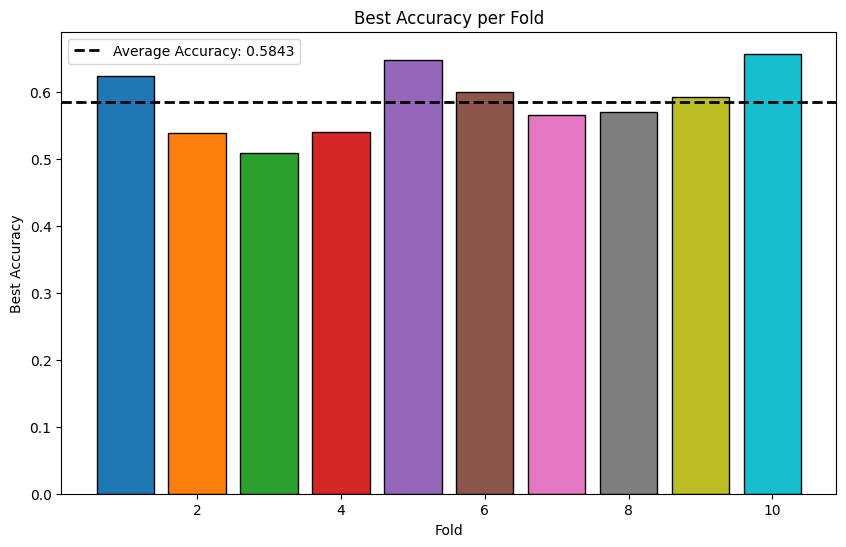

In [13]:
cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, len(best_accuracies)))

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(best_accuracies) + 1), best_accuracies, color=colors, edgecolor='black')
plt.axhline(y=mean_accuracy, color='black', linestyle='--', label=f'Average Accuracy: {mean_accuracy:.4f}', linewidth=2)
plt.xlabel('Fold')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy per Fold')
plt.legend()
plt.show()

### Accuracies por clase

In [14]:
# Extraer las precisiones por clase y fold
num_classes = 10 # Numero de clases
num_folds = len(folds_performance)
class_accuracies_train = np.zeros((num_folds, num_classes))
class_accuracies_val = np.zeros((num_folds, num_classes))

for i, fold_result in enumerate(folds_performance):
    train_report = fold_result['train_report']
    val_report = fold_result['val_report']
    for class_idx in range(num_classes):
        class_label = str(class_idx)
        if class_label in train_report:
            class_accuracies_train[i, class_idx] = train_report[class_label]['precision']
        if class_label in val_report:
            class_accuracies_val[i, class_idx] = val_report[class_label]['precision']
            
# Calcular el promedio por clase para entrenamiento y validación
mean_class_accuracies_train = np.mean(class_accuracies_train, axis=0)
mean_class_accuracies_val = np.mean(class_accuracies_val, axis=0)

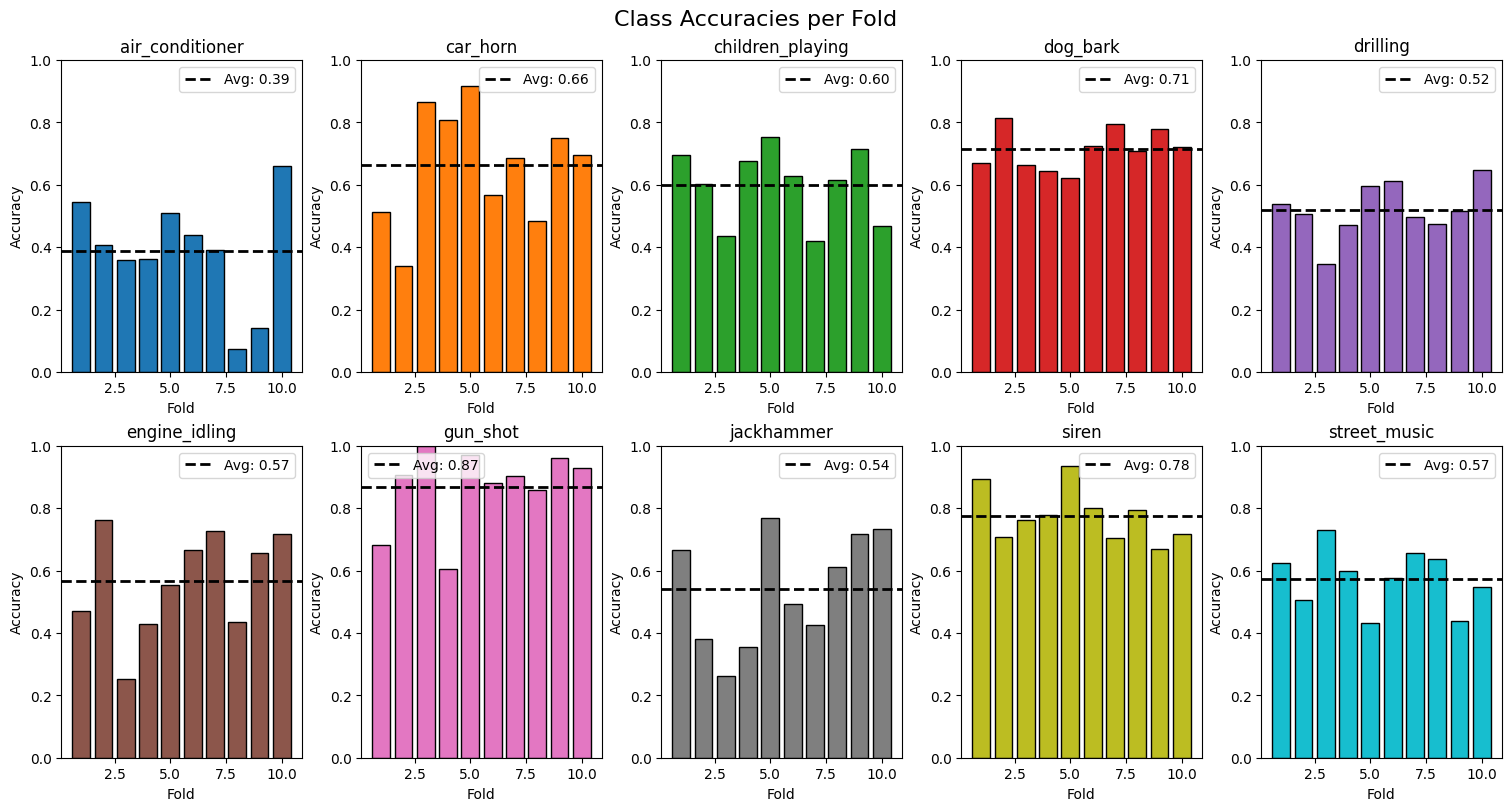

In [15]:
# Definir el layout de los subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 8), constrained_layout=True)
fig.suptitle('Class Accuracies per Fold', fontsize=16)

for class_idx in range(num_classes):
    row = class_idx // 5
    col = class_idx % 5
    ax = axs[row, col]
    
    # Accuracies de cada fold para la clase actual
    accuracies_per_fold = class_accuracies_val[:, class_idx]
    
    # Asignar un color único a todas las barras del subplot (un color distinto por subplot)
    color_option = cmap(class_idx % 10)
    
    # Mismo color para todas las barras en el subplot, pero distinto para cada clase
    ax.bar(range(1, num_folds + 1), accuracies_per_fold, color=color_option, edgecolor='black')
    
    # Línea de promedio
    avg_accuracy = mean_class_accuracies_val[class_idx]
    ax.axhline(y=avg_accuracy, color='black', linestyle='--', label=f'Avg: {avg_accuracy:.2f}', linewidth=2)
    
    # Usar el mapeo para el título de cada clase
    class_name = class_mapping.get(class_idx, f'Class {class_idx}')
    ax.set_title(class_name)
    ax.set_xlabel('Fold')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.legend()

plt.show()

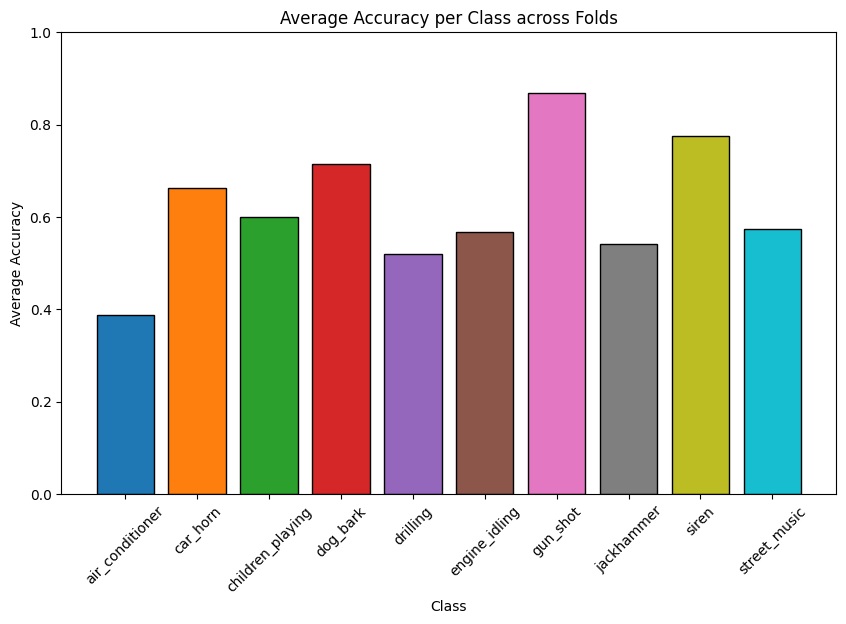

In [16]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), mean_class_accuracies_val, color=colors, edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy per Class across Folds')
plt.ylim(0, 1)

# Usar el mapeo para mostrar los nombres de las clases en el eje x
class_labels = [class_mapping.get(i, f'Class {i}') for i in range(num_classes)]
plt.xticks(range(num_classes), class_labels, rotation=45)

plt.show()

### Reportes de clasificacion

In [17]:
print("Validation Classification Report per Fold with Overall Metrics:")

for fold_result in folds_performance:
    print(f"\nFold {fold_result['fold']} - Validation Classification Report:")
    val_report = fold_result['val_report']
    
    # Mostrar métricas por clase solo con el nombre de la clase
    for label, metrics in val_report.items():
        if label.isdigit():  # Solo mostrar métricas por clase
            class_name = class_mapping.get(int(label), "Unknown Class")  # Obtener nombre de la clase
            print(f"{class_name}: Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-Score: {metrics['f1-score']:.4f}")
    
    # Mostrar métricas generales
    if 'macro avg' in val_report:
        general_metrics = val_report['macro avg']
        print("\nGeneral Metrics (Macro Average):")
        print(f"Precision: {general_metrics['precision']:.4f}, Recall: {general_metrics['recall']:.4f}, F1-Score: {general_metrics['f1-score']:.4f}")
    elif 'weighted avg' in val_report:
        general_metrics = val_report['weighted avg']
        print("\nGeneral Metrics (Weighted Average):")
        print(f"Precision: {general_metrics['precision']:.4f}, Recall: {general_metrics['recall']:.4f}, F1-Score: {general_metrics['f1-score']:.4f}")


Validation Classification Report per Fold with Overall Metrics:

Fold 1 - Validation Classification Report:
air_conditioner: Precision: 0.5444, Recall: 0.4900, F1-Score: 0.5158
car_horn: Precision: 0.5116, Recall: 0.6111, F1-Score: 0.5570
children_playing: Precision: 0.6951, Recall: 0.5700, F1-Score: 0.6264
dog_bark: Precision: 0.6699, Recall: 0.6900, F1-Score: 0.6798
drilling: Precision: 0.5370, Recall: 0.5800, F1-Score: 0.5577
engine_idling: Precision: 0.4717, Recall: 0.5208, F1-Score: 0.4950
gun_shot: Precision: 0.6818, Recall: 0.8571, F1-Score: 0.7595
jackhammer: Precision: 0.6645, Recall: 0.8417, F1-Score: 0.7426
siren: Precision: 0.8923, Recall: 0.6744, F1-Score: 0.7682
street_music: Precision: 0.6250, Recall: 0.5000, F1-Score: 0.5556

General Metrics (Macro Average):
Precision: 0.6293, Recall: 0.6335, F1-Score: 0.6258

Fold 2 - Validation Classification Report:
air_conditioner: Precision: 0.4082, Recall: 0.4000, F1-Score: 0.4040
car_horn: Precision: 0.3390, Recall: 0.4762, F1-Sc

### Historico de Perdidas

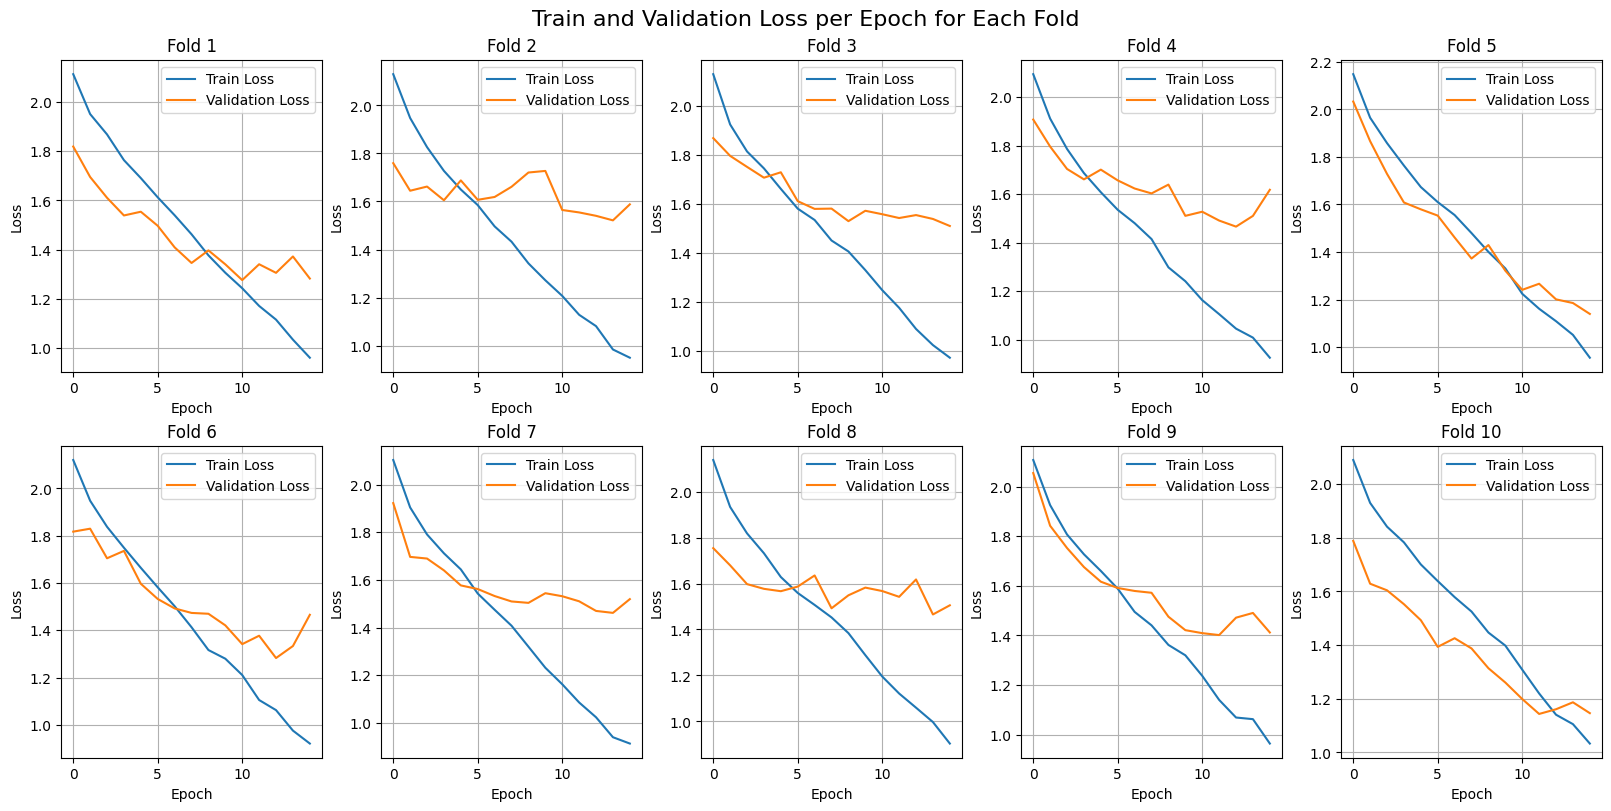

In [18]:
# Definir el número de épocas (asumiendo que todos los folds tienen la misma cantidad de épocas)
num_epochs = len(folds_performance[0]['train_losses'])

# Inicializar arrays para acumular las pérdidas de entrenamiento y validación
avg_train_losses = np.zeros(num_epochs)
avg_val_losses = np.zeros(num_epochs)

# Acumular las pérdidas de cada fold
for fold_result in folds_performance:
    avg_train_losses += np.array(fold_result['train_losses'])
    avg_val_losses += np.array(fold_result['val_losses'])

# Calcular el promedio dividiendo por el número de folds
avg_train_losses /= len(folds_performance)
avg_val_losses /= len(folds_performance)

# Crear los subplots para cada fold
fig, axs = plt.subplots(2, 5, figsize=(16, 8), constrained_layout=True)
fig.suptitle('Train and Validation Loss per Epoch for Each Fold', fontsize=16)

for i, fold_result in enumerate(folds_performance):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    
    # Extraer pérdidas de entrenamiento y validación
    train_losses = fold_result['train_losses']
    val_losses = fold_result['val_losses']
    
    # Graficar las pérdidas en el subplot correspondiente
    ax.plot(train_losses, label='Train Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_title(f'Fold {fold_result["fold"]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

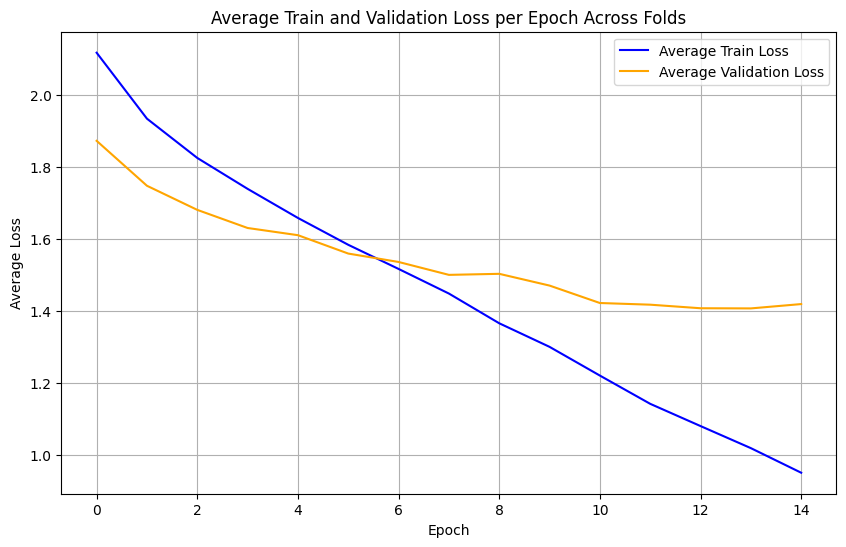

In [19]:
# Gráfico adicional para las pérdidas promedio
plt.figure(figsize=(10, 6))
plt.plot(avg_train_losses, label='Average Train Loss', color='blue')
plt.plot(avg_val_losses, label='Average Validation Loss', color='orange')
plt.title('Average Train and Validation Loss per Epoch Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

### Historico de Precisiones

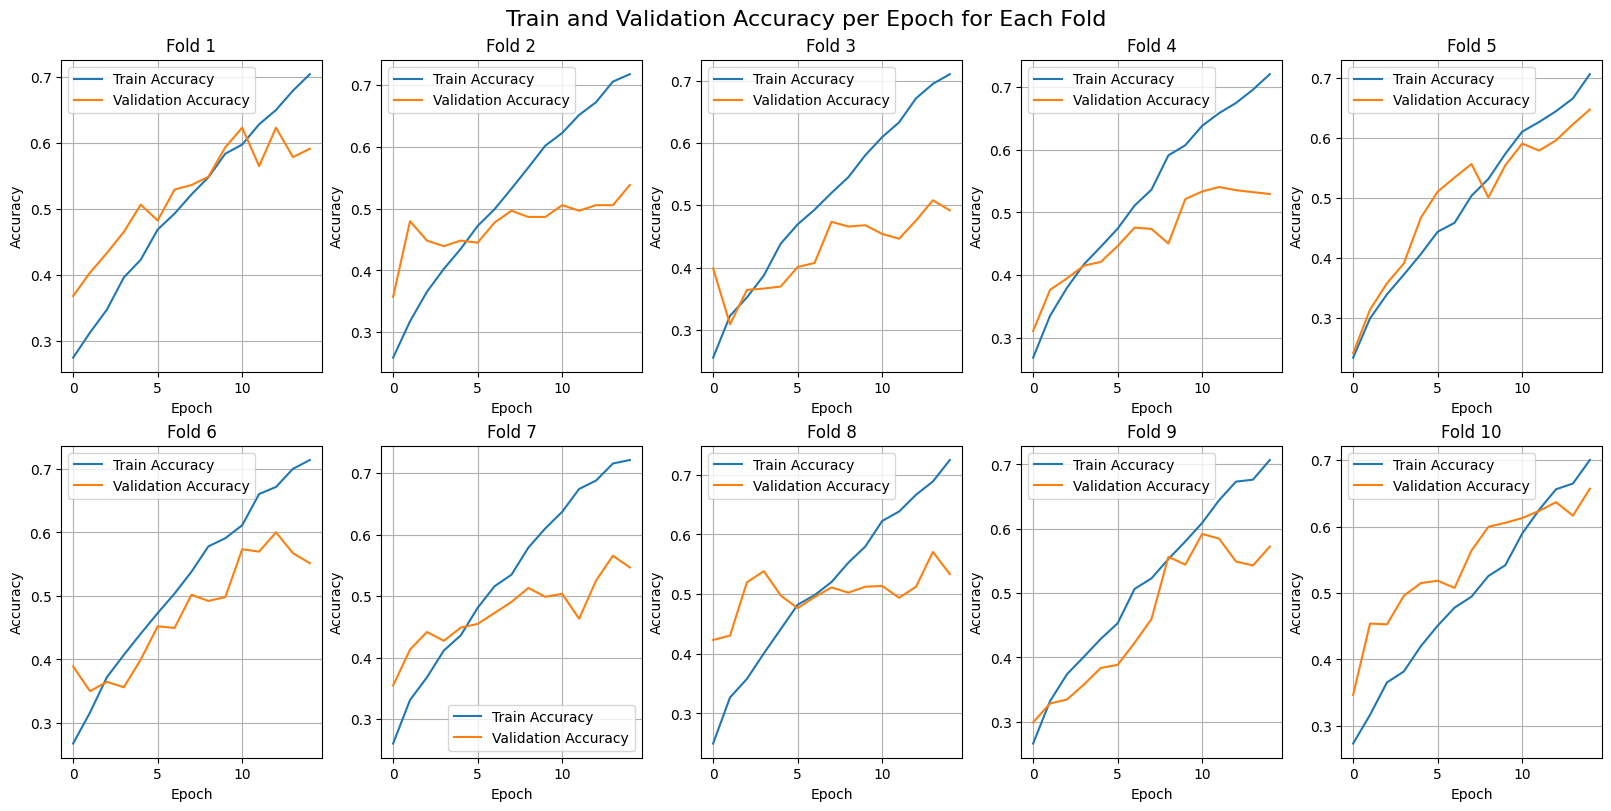

In [20]:
# Definir el número de épocas (asumiendo que todos los folds tienen la misma cantidad de épocas)
num_epochs = len(folds_performance[0]['train_accuracies'])

# Inicializar arrays para acumular las precisiones de entrenamiento y validación
avg_train_accuracies = np.zeros(num_epochs)
avg_val_accuracies = np.zeros(num_epochs)

# Acumular las precisiones de cada fold
for fold_result in folds_performance:
    avg_train_accuracies += np.array(fold_result['train_accuracies'])
    avg_val_accuracies += np.array(fold_result['val_accuracies'])

# Calcular el promedio dividiendo por el número de folds
avg_train_accuracies /= len(folds_performance)
avg_val_accuracies /= len(folds_performance)

# Crear los subplots para cada fold
fig, axs = plt.subplots(2, 5, figsize=(16, 8), constrained_layout=True)
fig.suptitle('Train and Validation Accuracy per Epoch for Each Fold', fontsize=16)

for i, fold_result in enumerate(folds_performance):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    
    # Extraer precisiones de entrenamiento y validación
    train_accuracies = fold_result['train_accuracies']
    val_accuracies = fold_result['val_accuracies']
    
    # Graficar las precisiones en el subplot correspondiente
    ax.plot(train_accuracies, label='Train Accuracy')
    ax.plot(val_accuracies, label='Validation Accuracy')
    ax.set_title(f'Fold {fold_result["fold"]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

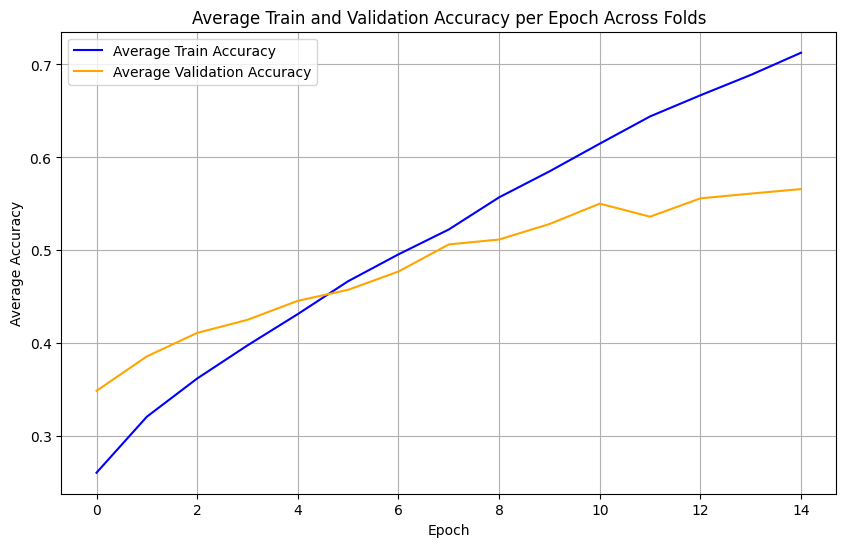

In [21]:
# Gráfico adicional para las precisiones promedio
plt.figure(figsize=(10, 6))
plt.plot(avg_train_accuracies, label='Average Train Accuracy', color='blue')
plt.plot(avg_val_accuracies, label='Average Validation Accuracy', color='orange')
plt.title('Average Train and Validation Accuracy per Epoch Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Matrices de Confusion

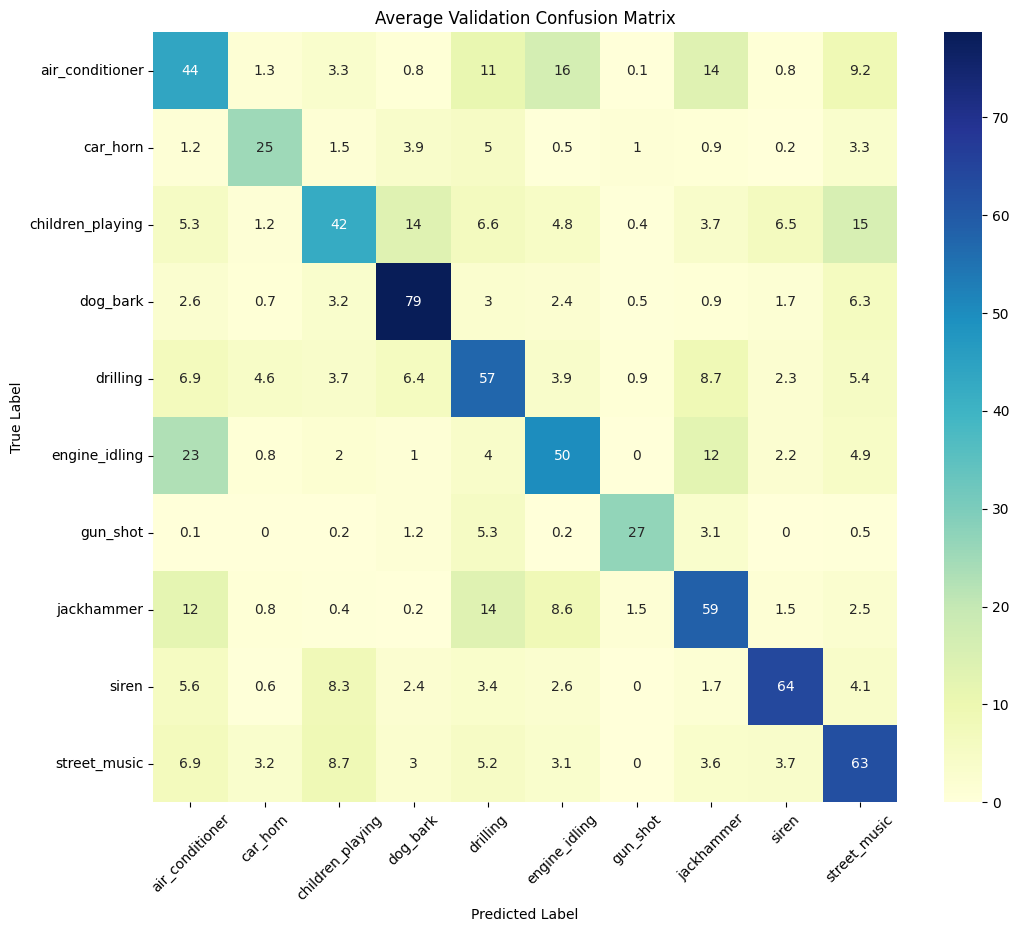

In [22]:
# Inicializar una matriz para acumular las matrices de confusión de validación
num_classes = folds_performance[0]['val_matrix'].shape[0]
avg_conf_matrix = np.zeros((num_classes, num_classes), dtype=float)

# Acumular las matrices de confusión de cada fold
for fold_result in folds_performance:
    avg_conf_matrix += fold_result['val_matrix']

# Calcular el promedio dividiendo por el número de folds
avg_conf_matrix /= len(folds_performance)

# Obtener las etiquetas de clase usando el mapeo
class_labels = [class_mapping[i] for i in range(num_classes)]

# Graficar la matriz de confusión promedio
plt.figure(figsize=(12, 10))
sns.heatmap(avg_conf_matrix, annot=True, cmap="YlGnBu", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Average Validation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.ylabel("True Label")
plt.show()

## Modelo Combinado

Ya que se ha realizado la cross validation, esto nos permite tener un estimado de como rendira el modelo cuando sea entrenado con todos los datos disponibles.

In [13]:
# Crear dataset con todos los datos
full_dataset = AudioDataset(paths, labels, train=True)

# Crear dataloader con todo el dataset
full_loader = DataLoader(full_dataset, batch_size=128, shuffle=False, collate_fn=collate_data)

# Configurar el nuevo modelo
full_model = AudioLSTM(feature_size=FEATURE_SIZE,
                          out_features=OUT_FEATURE,
                          hidden_layers=256,
                          layers=2,
                          dropout=0.3).to(device)

# Crear un optimizador y un scheduler
full_optimizer = optim.AdamW(full_model.parameters(), lr=1e-3, weight_decay=1e-3)
full_scheduler = optim.lr_scheduler.ReduceLROnPlateau(full_optimizer, mode='max', patience=SCHEDULER_PATIENCE, factor=0.1)

# Inicializar variable para guardar el mejor accuracy
full_best_accuracy = 0
full_best_epoch = 0

# Entrenar el modelo con todos los datos
print("-"*15, " FULL MODEL ", "-"*15)
# Iterar por cada época
for epoch in range(EPOCHS):
    # Entrenar el modelo y obtener las métricas
    full_epoch_train_loss, full_epoch_train_acc, _, _ = train_model(full_loader, full_model, epoch, full_optimizer, device)

    # Actualizar el scheduler y guardar el mejor modelo
    full_scheduler.step(full_epoch_train_acc)

    # Guardar el mejor modelo y métricas de desempeño
    if full_epoch_train_acc > full_best_accuracy:
        # Actualizar el mejor accuracy y epoch
        full_best_accuracy = full_epoch_train_acc
        full_best_epoch = epoch

        # Guardar el mejor modelo hasta ahora
        save_model({'model_state_dict': full_model.state_dict(), 'optimizer_state_dict': full_optimizer.state_dict()}, 'models/lstmv2_full.pth')
    
# Imprimir el mejor accuracy obtenido
print("-"*15, "\n")
print(f"\nBest Accuracy: {full_best_accuracy:.4f}")

---------------  FULL MODEL  ---------------


TRAIN -> Epoch 0 | Batch: 69/69 | Loss: 2.0954 | Accuracy: 0.3214: 100%|██████████| 69/69 [00:41<00:00,  1.67it/s]


TRAIN -> Epoch 0 | Final Loss: 2.1324 | Final Accuracy: 0.2705


TRAIN -> Epoch 1 | Batch: 69/69 | Loss: 1.8891 | Accuracy: 0.3214: 100%|██████████| 69/69 [00:41<00:00,  1.65it/s]


TRAIN -> Epoch 1 | Final Loss: 1.9419 | Final Accuracy: 0.3274


TRAIN -> Epoch 2 | Batch: 69/69 | Loss: 1.5492 | Accuracy: 0.3571: 100%|██████████| 69/69 [00:39<00:00,  1.73it/s]


TRAIN -> Epoch 2 | Final Loss: 1.8402 | Final Accuracy: 0.3538


TRAIN -> Epoch 3 | Batch: 69/69 | Loss: 1.3114 | Accuracy: 0.4643: 100%|██████████| 69/69 [00:40<00:00,  1.71it/s]


TRAIN -> Epoch 3 | Final Loss: 1.7217 | Final Accuracy: 0.4048


TRAIN -> Epoch 4 | Batch: 69/69 | Loss: 1.3467 | Accuracy: 0.5714: 100%|██████████| 69/69 [00:39<00:00,  1.73it/s]


TRAIN -> Epoch 4 | Final Loss: 1.6590 | Final Accuracy: 0.4276


TRAIN -> Epoch 5 | Batch: 69/69 | Loss: 0.9717 | Accuracy: 0.8214: 100%|██████████| 69/69 [00:39<00:00,  1.75it/s]


TRAIN -> Epoch 5 | Final Loss: 1.5817 | Final Accuracy: 0.4573


TRAIN -> Epoch 6 | Batch: 69/69 | Loss: 0.8765 | Accuracy: 0.8571: 100%|██████████| 69/69 [00:42<00:00,  1.63it/s]


TRAIN -> Epoch 6 | Final Loss: 1.5034 | Final Accuracy: 0.4918


TRAIN -> Epoch 7 | Batch: 69/69 | Loss: 0.9463 | Accuracy: 0.7857: 100%|██████████| 69/69 [00:39<00:00,  1.73it/s]


TRAIN -> Epoch 7 | Final Loss: 1.4343 | Final Accuracy: 0.5236


TRAIN -> Epoch 8 | Batch: 69/69 | Loss: 1.0115 | Accuracy: 0.7143: 100%|██████████| 69/69 [01:26<00:00,  1.26s/it]


TRAIN -> Epoch 8 | Final Loss: 1.3879 | Final Accuracy: 0.5442


TRAIN -> Epoch 9 | Batch: 69/69 | Loss: 0.7541 | Accuracy: 0.8214: 100%|██████████| 69/69 [01:06<00:00,  1.04it/s]


TRAIN -> Epoch 9 | Final Loss: 1.3182 | Final Accuracy: 0.5644


TRAIN -> Epoch 10 | Batch: 69/69 | Loss: 0.5203 | Accuracy: 0.9643: 100%|██████████| 69/69 [00:39<00:00,  1.73it/s]


TRAIN -> Epoch 10 | Final Loss: 1.2408 | Final Accuracy: 0.5963


TRAIN -> Epoch 11 | Batch: 69/69 | Loss: 0.4870 | Accuracy: 0.8929: 100%|██████████| 69/69 [00:39<00:00,  1.74it/s]


TRAIN -> Epoch 11 | Final Loss: 1.1735 | Final Accuracy: 0.6199


TRAIN -> Epoch 12 | Batch: 69/69 | Loss: 0.3775 | Accuracy: 0.9643: 100%|██████████| 69/69 [00:40<00:00,  1.72it/s]


TRAIN -> Epoch 12 | Final Loss: 1.1095 | Final Accuracy: 0.6427


TRAIN -> Epoch 13 | Batch: 69/69 | Loss: 0.4296 | Accuracy: 0.9286: 100%|██████████| 69/69 [00:39<00:00,  1.73it/s]


TRAIN -> Epoch 13 | Final Loss: 1.0516 | Final Accuracy: 0.6682


TRAIN -> Epoch 14 | Batch: 69/69 | Loss: 0.2186 | Accuracy: 1.0000: 100%|██████████| 69/69 [00:39<00:00,  1.73it/s]

TRAIN -> Epoch 14 | Final Loss: 0.9743 | Final Accuracy: 0.6943
--------------- 


Best Accuracy: 0.6943
